In [2]:
import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda
np.random.seed(1)
random.seed(1)
snapshot_folder = '../../chatbot_weights_v2'
data_path = '../../movie_dialogue/'

# assert os.path.isdir(snapshot_folder) == True
# assert os.path.isdir(data_path) == True
print(tf.__version__)

test = False
print('test: ', test)
if test:
    GRU_units = 10
    batch_size = 4
    emb_dim = 10
else:
    GRU_units = 256
    batch_size = 32
    emb_dim = 50

init_lr = 0.0005

1.14.0
test:  False


In [3]:
def progressBar(value, endvalue, bar_length=20, job='Job'):

    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job,arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()
    
def print_tensor(t):
    print(K.get_value(t))
    
def to_tensor(t):
    return tf.convert_to_tensor(t)

#### Reading the data

In [4]:
# Load the data
lines = open(data_path+'movie_lines.txt', encoding='utf-8', errors='ignore').read().split('\n')
conv_lines = open(data_path+'movie_conversations.txt', encoding='utf-8', errors='ignore').read().split('\n') # index of related lines

# Create a dictionary to map each line's id with its text
id2line = {}
for line in lines:
    _line = line.split(' +++$+++ ')
    if len(_line) == 5:
        id2line[_line[0]] = _line[4]
        
# Create a list of all of the conversations' lines' ids.
convs = [ ]
for line in conv_lines[:-1]:
    _line = line.split(' +++$+++ ')[-1][1:-1].replace("'","").replace(" ","")
    convs.append(_line.split(','))

# Sort the sentences into questions (inputs) and answers (targets)
pairs = []
for conv in convs:
    for i in range(len(conv)-1):
        pairs.append([id2line[conv[i]],id2line[conv[i+1]]])
        
# Check if we have loaded the data correctly
limit = 0
for i in range(limit, limit+5):
    print(pairs[i][0])
    print(pairs[i][1])
    print()
    
len(pairs)

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
Well, I thought we'd start with pronunciation, if that's okay with you.

Well, I thought we'd start with pronunciation, if that's okay with you.
Not the hacking and gagging and spitting part.  Please.

Not the hacking and gagging and spitting part.  Please.
Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?

You're asking me out.  That's so cute. What's your name again?
Forget it.

No, no, it's my fault -- we didn't have a proper introduction ---
Cameron.



221616

In [5]:
# replacing many abbreviations and lower casing the words
def replace_phrase(pairs):
    p = pairs.copy()

    for i in p:
        for j in range(0,2):
            i[j] = i[j].lower()
            i[j] = re.sub(r"there's", "there is", i[j])
            i[j] = re.sub(r"i'm", "i am", i[j])
            i[j] = re.sub(r"he's", "he is", i[j])
            i[j] = re.sub(r"she's", "she is", i[j])
            i[j] = re.sub(r"it's", "it is", i[j])
            i[j] = re.sub(r"that's", "that is", i[j])
            i[j] = re.sub(r"what's", "that is", i[j])
            i[j] = re.sub(r"where's", "where is", i[j])
            i[j] = re.sub(r"how's", "how is", i[j])
            i[j] = re.sub(r"\'ll", " will", i[j])
            i[j] = re.sub(r"\'ve", " have", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"\'d", " would", i[j])
            i[j] = re.sub(r"\'re", " are", i[j])
            i[j] = re.sub(r"won't", "will not", i[j])
            i[j] = re.sub(r"can't", "cannot", i[j])
            i[j] = re.sub(r"n't", " not", i[j])
            i[j] = re.sub(r"n'", "ng", i[j])
            i[j] = re.sub(r"'bout", "about", i[j])
            i[j] = re.sub(r"'til", "until", i[j])
            i[j] = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", i[j])
            i[j] = i[j].strip()
    return p
replaced_pairs = replace_phrase(pairs)
replaced_pairs[:5]

[['can we make this quick  roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad  again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part  please'],
 ['not the hacking and gagging and spitting part  please',
  'okay then how about we try out some french cuisine  saturday  night'],
 ['you are asking me out  that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault  we did not have a proper introduction', 'cameron']]

In [6]:
def clean_data(pairs):
    p = pairs.copy()
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for i in p:
        # tokenize
        i[0], i[1] = i[0].split(), i[1].split()
        # convert to lower case
        i[0], i[1] = [word.lower() for word in i[0]], [word.lower() for word in i[1]]
        # remove punctuation from each token
        i[0], i[1] = [w.translate(table) for w in i[0]], [w.translate(table) for w in i[1]]
        # remove tokens with numbers in them
        i[0], i[1] = [word for word in i[0] if word.isalpha()], [word for word in i[1] if word.isalpha()]
        # store as string
        i[0], i[1] =  ' '.join(i[0]), ' '.join(i[1])
            
    return p

clean_pairs = clean_data(replaced_pairs)
clean_pairs[:5]

[['can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again',
  'well i thought we would start with pronunciation if that is okay with you'],
 ['well i thought we would start with pronunciation if that is okay with you',
  'not the hacking and gagging and spitting part please'],
 ['not the hacking and gagging and spitting part please',
  'okay then how about we try out some french cuisine saturday night'],
 ['you are asking me out that is so cute that is your name again',
  'forget it'],
 ['no no it is my fault we did not have a proper introduction', 'cameron']]

In [7]:
# adding the start and end token to our sentences
start_token = '<startseq>'
end_token = '<endseq>'

def add_end_start_tokens(pairs):
    p = pairs.copy()
    for i in p:
        i[0] = start_token + ' '  + i[0] + ' ' + end_token
        i[1] = start_token + ' '  + i[1] + ' ' + end_token
    return p

tokenized_pairs = add_end_start_tokens(clean_pairs)
tokenized_pairs[:5]

[['<startseq> can we make this quick roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad again <endseq>',
  '<startseq> well i thought we would start with pronunciation if that is okay with you <endseq>'],
 ['<startseq> well i thought we would start with pronunciation if that is okay with you <endseq>',
  '<startseq> not the hacking and gagging and spitting part please <endseq>'],
 ['<startseq> not the hacking and gagging and spitting part please <endseq>',
  '<startseq> okay then how about we try out some french cuisine saturday night <endseq>'],
 ['<startseq> you are asking me out that is so cute that is your name again <endseq>',
  '<startseq> forget it <endseq>'],
 ['<startseq> no no it is my fault we did not have a proper introduction <endseq>',
  '<startseq> cameron <endseq>']]

In [8]:
# finding the maximum length of questions and answers
# because there are senteces with unusually long lengths, we caculate the max length that 80% of data can be placed in
def max_length(pairs,prct):
    # Create a list of all the captions
    questions = []
    answers = []
    for i in pairs:
        questions.append(i[0])
        answers.append(i[1])
        
    length_questions = list(len(d.split()) for d in questions)
    length_answers = list(len(d.split()) for d in answers)

    print('percentile {} of len of questions: {}'.format(prct,np.percentile(length_questions, prct)))
    print('longest sentence: ', max(length_questions))
    print()
    print('percentile {} of len of answers: {}'.format(prct,np.percentile(length_answers, prct)))
    print('longest sentence: ', max(length_answers))
    print()
    return int(np.percentile(length_questions, prct)),int(np.percentile(length_answers, prct))

max_len_q,max_len_a = max_length(tokenized_pairs,80)

print('max-len questions for training: ', max_len_q)
print('max-len answers for training: ', max_len_a)

percentile 80 of len of questions: 18.0
longest sentence:  321

percentile 80 of len of answers: 18.0
longest sentence:  557

max-len questions for training:  18
max-len answers for training:  18


In [9]:
# Remove questions and answers that are shorter than 2 words and longer than maxlen.
min_line_len = 2 # two words are for tokens

def set_length(tokenized_pairs):
    pairs_final = []
    for p in tokenized_pairs:
        if (
            len(p[0].split())>=min_line_len and len(p[1].split())>=min_line_len 
           and len(p[0].split())<=max_len_q and len(p[1].split())<=max_len_a):
                
            pairs_final.append(p)
            
    return pairs_final

pairs_final = set_length(tokenized_pairs)
len(pairs_final)

145905

#### Creating the vocabulary

In [10]:
# making a vocabulary of the words that occur more than word_count_threshold time
def create_reoccurring_vocab(pairs, word_count_threshold = 5):
    p = pairs
    # Create a list of all the captions
    all_captions = []
    for i in p:
        for j in i:
            all_captions.append(j)

    # Consider only words which occur at least 10 times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
    vocab = list(set(vocab))
    print('Short vocab size: %d ' % len(vocab))
    return vocab

# each word in the vocabulary must be used in the data atleast 20 times
short_vocab = create_reoccurring_vocab(pairs_final, word_count_threshold = 4)
# removing one character words from vocab except for 'a'
for v in short_vocab:
    if len(v) == 1 and v!='a' and v!='i':
        short_vocab.remove(v) 

short_vocab = sorted(short_vocab)[1:]
short_vocab[:5]

Short vocab size: 14524 


['<endseq>', '<startseq>', 'a', 'aa', 'aaaah']

In [11]:
vocab_len = len(short_vocab) + 1 # since index 0 is used as padding, we have to increase the vocab size
vocab_len

14500

In [14]:
# keep the pairs that have the words in vocab
def trimRareWords(voc, pairs):
    # Filter out pairs with trimmed words
    keep_pairs = []
    i=0
    for pair in pairs:
        i+=1
        progressBar(value=i,endvalue=len(pairs))
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("\nTrimmed from {} pairs to {}".format(len(pairs), len(keep_pairs)))
    return keep_pairs


# # Trim voc and pairs
pairs_final = trimRareWords(short_vocab, pairs_final)
with open ('final_pairs_v21.pkl','wb') as f:
    pairs_final = pickle.dump(pairs_final,f)
    
with open ('final_pairs_v21.pkl','rb') as f:
    pairs_final = pickle.load(f)
    
pairs_final_train = pairs_final
len(pairs_final_train)

Job Completion: [------------------->] 100%
Trimmed from 145905 pairs to 115304


115304

In [15]:
#Create an instance of the tokenizer object:
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(short_vocab)

ixtoword = {} # index to word dic
wordtoix = tokenizer.word_index # word to index dic
pad_token = 'pad0'
ixtoword[0] = pad_token # no word in vocab has index 0. but padding is indicated with 0

for w in tokenizer.word_index:
    ixtoword[tokenizer.word_index[w]] = w

#### making the model

In [16]:
 # Making the embedding mtrix
def make_embedding_layer(embedding_dim=100, glove=True):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        glove_dir = '../../../glove'
        embeddings_index = {} 
        f = open(os.path.join(glove_dir, 'glove.6B.'+str(embedding_dim)+'d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        print("GloVe ",embedding_dim, ' loded!')
        # Get 200-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    
    return embedding_layer

embeddings = make_embedding_layer(embedding_dim=emb_dim, glove=not test)

Loading glove...
GloVe  50  loded!


In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.batch_sz = batch_size
        self.enc_units = enc_units
        self.embeddings = embeddings
        
        self.Bidirectional1 = Bidirectional(GRU(enc_units, 
                                                return_sequences=True, 
                                                return_state=True,
                                                recurrent_initializer='glorot_uniform',
                                                name='gru_1'), name='bidirectional_encoder1')
                                                                                                
        self.dropout = Dropout(0.2)
        self.Inp = Input(shape=(max_len_q,)) # size of questions
    
    def call(self, x, hidden):
        x = self.embeddings(x)
        x = self.dropout(x)
        output, state_f, state_b = self.Bidirectional1(x)

        return output, state_f, state_b

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(emb_dim, GRU_units)

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units = units
        
    def call(self, query, values):
        
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [20]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.batch_sz = batch_size
        self.embeddings = embeddings
        self.units = 2 * dec_units # because we use bidirectional encoder
        self.fc = Dense(vocab_len, activation='softmax', name='dense_layer')
        # used for attention
        self.attention = BahdanauAttention(self.units)
        self.decoder_gru_l1 = GRU(self.units, return_sequences=True, 
                                  return_state= False, recurrent_initializer='glorot_uniform' ,name='decoder_gru1')
        self.decoder_gru_l2 = GRU(self.units, return_sequences=False, 
                                  return_state= True, recurrent_initializer='glorot_uniform' ,name='decoder_gru2') 
        self.dropout = Dropout(0.4)
        
    def call(self, x, hidden, enc_output):

        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embeddings(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) # concat input and context vector together

        # passing the concatenated vector to the GRU
        x = self.decoder_gru_l1(x)
        x = self.dropout(x)
        output, state = self.decoder_gru_l2(x)
        x = self.fc(output)
        return x, state, attention_weights

In [21]:
decoder = Decoder(vocab_len, emb_dim, GRU_units)

## Replying questions

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [22]:
import unicodedata
import matplotlib.ticker as ticker

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [84]:
def evaluate(sentence):
    
    attention_plot = np.zeros((max_len_a, max_len_q))

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 1)

    for t in range(max_len_a):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = K.get_value(attention_weights)
        
        predicted_id =  K.get_value(tf.argmax(predictions[0]))       

        if ixtoword[predicted_id] == end_token:
            return result, sentence, attention_plot
        
        result += ixtoword[predicted_id] + ' '
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 1)

    return result, sentence, attention_plot

In [83]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()

In [130]:
def answer(sentence, training=False):
    result, sentence, attention_plot = evaluate(sentence)
    
    if training:
        return result
    
    print('Input: %s' % (sentence))
    print('Predicted answer: {}'.format(result))
    attention_plot = attention_plot[1:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' ')[:-1])

In [27]:
def beam_search(sentence, k=3, maxsample=max_len_a, use_unk=False, oov=None, eos=end_token):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    
    dead_k = 0 # samples that reached eos
    dead_samples = []
    dead_scores = []
    live_k = 1 # samples that did not yet reached eos
    live_samples = [[wordtoix[start_token]]]
    live_scores = [0]

    sentence = unicode_to_ascii(sentence.lower())
    inputs = [wordtoix[i] for i in sentence.split(' ')]
    inputs = [wordtoix[start_token]]+inputs+[wordtoix[end_token]]
    inputs = pad_sequences([inputs],maxlen=max_len_q, padding='post')

    inputs = tf.convert_to_tensor(inputs)

    hidden = [tf.zeros((1, GRU_units))]
    enc_out, enc_hidden_f, enc_hidden_b = encoder(inputs, hidden)

    dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
    dec_input = tf.expand_dims([wordtoix[start_token]], 0)
        
    while live_k and dead_k < k:
        # for every possible live sample calc prob for every possible label 
        predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_out)
        probs = K.get_value(predictions[0])
        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        cand_flat = cand_scores.flatten()

        # find the best (lowest) scores we have from all possible samples and new words
        ranks_flat = cand_flat.argsort()[:(k-dead_k)]
        live_scores = cand_flat[ranks_flat]

        # append the new words to their appropriate live sample
        voc_size = vocab_len
        live_samples = [live_samples[r//voc_size]+[r%voc_size] for r in ranks_flat]

        # live samples that should be dead are...
        zombie = [s[-1] == eos or len(s) >= maxsample for s in live_samples]
        
        # add zombies to the dead
        dead_samples += [s for s,z in zip(live_samples,zombie) if z]  # remove first label == empty
        dead_scores += [s for s,z in zip(live_scores,zombie) if z]
        dead_k = len(dead_samples)
        # remove zombies from the living 
        live_samples = [s for s,z in zip(live_samples,zombie) if not z]
        live_scores = [s for s,z in zip(live_scores,zombie) if not z]
        live_k = len(live_samples)

    final_samples = dead_samples + live_samples
    final_scores = dead_scores + live_scores   
    
    # cutting the strong where end_token is encounterd
    for i in range(len(final_scores)):
        final_scores[i] /= len(final_samples[i]) # normalizing the scores
    
    final_result =[]
    
    for i in range(len(final_scores)):
        final_result.append((final_scores[i],final_samples[i]))
    
    final_list_ix = max(final_result)[1]
    final_list_word = [ixtoword[f] for f in final_list_ix]
    final_sentence = ' '.join(final_list_word[1:])
    end_ix = final_sentence.find(end_token)
    return final_sentence[:end_ix]

## Define the optimizer and the loss function

In [29]:
optimizer = tf.keras.optimizers.Adam(init_lr)

def loss_function(real, pred):

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = K.sparse_categorical_crossentropy(real, pred, from_logits= False)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [30]:
# checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(snapshot_folder, str(emb_dim)+"-ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [31]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden_f, enc_hidden_b = encoder(inp, enc_hidden)
        
        dec_hidden = Concatenate(axis=-1)([enc_hidden_f, enc_hidden_b])
        dec_input = tf.expand_dims([wordtoix[start_token]] * batch_size, 1) # dec_input initially == start_token

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions) # each time just use one timestep output
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1) # expected output at this time becomes input for next timestep
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [32]:
history={'loss':[]}
smallest_loss = np.inf
best_ep = 1
EPOCHS = 1000 # but 150 is enough
enc_hidden = encoder.initialize_hidden_state()
steps_per_epoch = len(pairs_final_train)//batch_size # used for caculating number of batches
current_ep = 1

In [33]:
def test_bot(k = 3, beam = False):
    print('#'*20)
    q = 'Hello'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'How are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q= 'Are you my friend'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What are you doing'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'What your favorite restaurant'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'Who are you'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('%')
    q = 'Do you want to go out'
    print('Greedy| Q:',q,'?  A:',answer(q, training=True))
    if beam:print('Beam ',k,'| ',q,'?  A:',beam_search(q,k=k))
    print('#'*20)

In [34]:
def plot_history():
    plt.figure(figsize=(4,3))
    plt.plot(best_ep,smallest_loss,'ro')
    plt.plot(history['loss'],'b-')
    plt.legend(['best','loss'])
    plt.show()

Epoch 1 Batch 600 Loss: 1.9526
Epoch 1 Batch 1200 Loss: 1.9153
Epoch 1 Batch 1800 Loss: 1.3533
Epoch 1 Batch 2400 Loss: 2.6739
Epoch 1 Batch 3000 Loss: 2.0393
Epoch 1 Batch 3600 Loss: 1.8838

*** Epoch 1 Loss 2.0516 ***

####################
Greedy| Q: Hello ?  A: i am not you 
%
Greedy| Q: How are you ?  A: i am not you 
%
Greedy| Q: Are you my friend ?  A: i am not you 
%
Greedy| Q: What are you doing ?  A: i am not you 
%
Greedy| Q: What your favorite restaurant ?  A: i am not you 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: i am not you 
####################
check point saved!
Best epoch so far:  1  smallest loss: 2.051637470077019
Time taken for the epoch 261.752 sec

Epoch 2 Batch 600 Loss: 1.7679
Epoch 2 Batch 1200 Loss: 1.6755
Epoch 2 Batch 1800 Loss: 1.2667
Epoch 2 Batch 2400 Loss: 2.4256
Epoch 2 Batch 3000 Loss: 1.8603
Epoch 2 Batch 3600 Loss: 1.8349

*** Epoch 2 Loss 1.8166 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Gr

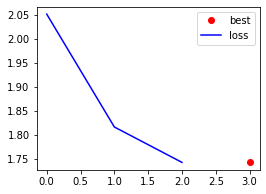

Best epoch so far:  3  smallest loss: 1.7428118440795866
Time taken for the epoch 242.520 sec

Epoch 4 Batch 600 Loss: 1.4169
Epoch 4 Batch 1200 Loss: 1.3321
Epoch 4 Batch 1800 Loss: 1.2883
Epoch 4 Batch 2400 Loss: 2.3974
Epoch 4 Batch 3000 Loss: 1.6133
Epoch 4 Batch 3600 Loss: 1.9623

*** Epoch 4 Loss 1.6880 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am not you 
%
Greedy| Q: Are you my friend ?  A: no i am not you 
%
Greedy| Q: What are you doing ?  A: i am not you 
%
Greedy| Q: What your favorite restaurant ?  A: i am not you 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: i am not you been 
####################
check point saved!
Best epoch so far:  4  smallest loss: 1.687983944586109
Time taken for the epoch 242.738 sec

Epoch 5 Batch 600 Loss: 1.4689
Epoch 5 Batch 1200 Loss: 1.4526
Epoch 5 Batch 1800 Loss: 1.1325
Epoch 5 Batch 2400 Loss: 2.3314
Epoch 5 Batch 3000 Loss: 1.7283
Epoch 5 Batch 3600 Lo

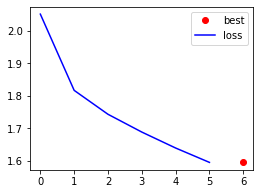

Best epoch so far:  6  smallest loss: 1.5944545723615737
Time taken for the epoch 242.801 sec

Epoch 7 Batch 600 Loss: 1.4744
Epoch 7 Batch 1200 Loss: 1.1598
Epoch 7 Batch 1800 Loss: 1.2875
Epoch 7 Batch 2400 Loss: 2.3275
Epoch 7 Batch 3000 Loss: 1.4092
Epoch 7 Batch 3600 Loss: 1.4070

*** Epoch 7 Loss 1.5535 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am not you 
%
Greedy| Q: Are you my friend ?  A: no i am not 
%
Greedy| Q: What are you doing ?  A: i am not you 
%
Greedy| Q: What your favorite restaurant ?  A: i am sorry i am not sure you are going to do it 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: i will not be a good time 
####################
check point saved!
Best epoch so far:  7  smallest loss: 1.553469710571052
Time taken for the epoch 243.001 sec

Epoch 8 Batch 600 Loss: 1.2532
Epoch 8 Batch 1200 Loss: 1.0661
Epoch 8 Batch 1800 Loss: 1.1714
Epoch 8 Batch 2400 Loss: 2.2511
Epoch 8 Batch 

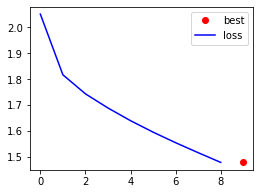

Best epoch so far:  9  smallest loss: 1.4772147613533861
Time taken for the epoch 242.911 sec

Epoch 10 Batch 600 Loss: 1.3175
Epoch 10 Batch 1200 Loss: 1.1188
Epoch 10 Batch 1800 Loss: 0.9855
Epoch 10 Batch 2400 Loss: 2.0581
Epoch 10 Batch 3000 Loss: 1.5085
Epoch 10 Batch 3600 Loss: 1.1931

*** Epoch 10 Loss 1.4414 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am not sure 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am not you 
%
Greedy| Q: What your favorite restaurant ?  A: no 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  10  smallest loss: 1.441402861981335
Time taken for the epoch 242.815 sec

Epoch 11 Batch 600 Loss: 1.2930
Epoch 11 Batch 1200 Loss: 0.9421
Epoch 11 Batch 1800 Loss: 1.1681
Epoch 11 Batch 2400 Loss: 2.1416
Epoch 11 Batch 3000 Loss: 1.3062
Epoch 11 Batch 3600 Loss: 1.2039



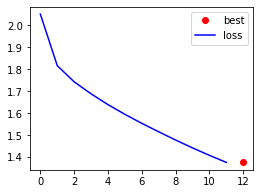

Best epoch so far:  12  smallest loss: 1.375281883152928
Time taken for the epoch 242.767 sec

Epoch 13 Batch 600 Loss: 1.1428
Epoch 13 Batch 1200 Loss: 1.0138
Epoch 13 Batch 1800 Loss: 0.9395
Epoch 13 Batch 2400 Loss: 2.0214
Epoch 13 Batch 3000 Loss: 1.3702
Epoch 13 Batch 3600 Loss: 1.1114

*** Epoch 13 Loss 1.3434 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am not going to do it 
%
Greedy| Q: What your favorite restaurant ?  A: no 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: no 
####################
check point saved!
Best epoch so far:  13  smallest loss: 1.3433582095215792
Time taken for the epoch 242.929 sec

Epoch 14 Batch 600 Loss: 1.1738
Epoch 14 Batch 1200 Loss: 0.9740
Epoch 14 Batch 1800 Loss: 0.9055
Epoch 14 Batch 2400 Loss: 1.8858
Epoch 14 Batch 3000 Loss: 1.3645
Epoch 14 Batch 3600 Loss: 1.0512

*** Epoc

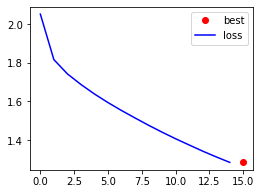

Best epoch so far:  15  smallest loss: 1.2852101872571469
Time taken for the epoch 242.708 sec

Epoch 16 Batch 600 Loss: 1.0514
Epoch 16 Batch 1200 Loss: 0.8138
Epoch 16 Batch 1800 Loss: 1.0003
Epoch 16 Batch 2400 Loss: 1.8913
Epoch 16 Batch 3000 Loss: 1.2348
Epoch 16 Batch 3600 Loss: 1.2474

*** Epoch 16 Loss 1.2581 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am not interested in nashville 
%
Greedy| Q: What your favorite restaurant ?  A: no i am not sure you are doing here 
%
Greedy| Q: Who are you ?  A: i am sorry 
%
Greedy| Q: Do you want to go out ?  A: no i do not know 
####################
check point saved!
Best epoch so far:  16  smallest loss: 1.2581281278188314
Time taken for the epoch 242.698 sec

Epoch 17 Batch 600 Loss: 0.9973
Epoch 17 Batch 1200 Loss: 0.8926
Epoch 17 Batch 1800 Loss: 0.8725
Epoch 17 Batch 2400 Loss: 1.8994
Epoch 17 Batch 3000 

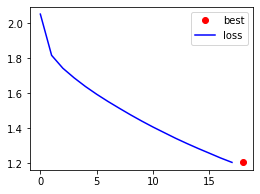

Best epoch so far:  18  smallest loss: 1.2058552009610046
Time taken for the epoch 242.703 sec

Epoch 19 Batch 600 Loss: 1.0792
Epoch 19 Batch 1200 Loss: 0.7127
Epoch 19 Batch 1800 Loss: 0.9910
Epoch 19 Batch 2400 Loss: 1.8036
Epoch 19 Batch 3000 Loss: 1.1097
Epoch 19 Batch 3600 Loss: 0.9777

*** Epoch 19 Loss 1.1817 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am not going to do 
%
Greedy| Q: What your favorite restaurant ?  A: no i do not know 
%
Greedy| Q: Who are you ?  A: i am sorry i am not you 
%
Greedy| Q: Do you want to go out ?  A: no i do not know 
####################
check point saved!
Best epoch so far:  19  smallest loss: 1.1817231571346793
Time taken for the epoch 242.863 sec

Epoch 20 Batch 600 Loss: 0.9555
Epoch 20 Batch 1200 Loss: 0.7271
Epoch 20 Batch 1800 Loss: 0.9158
Epoch 20 Batch 2400 Loss: 1.7668
Epoch 20 Batch 3000 Loss: 1.1567
Epoch

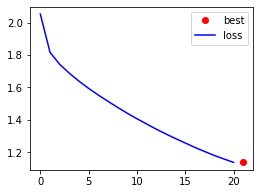

Best epoch so far:  21  smallest loss: 1.138839243122051
Time taken for the epoch 242.849 sec

Epoch 22 Batch 600 Loss: 0.9590
Epoch 22 Batch 1200 Loss: 0.7832
Epoch 22 Batch 1800 Loss: 0.7848
Epoch 22 Batch 2400 Loss: 1.6188
Epoch 22 Batch 3000 Loss: 1.1642
Epoch 22 Batch 3600 Loss: 0.8635

*** Epoch 22 Loss 1.1176 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am not sure i am not sure i am not sure i am not sure i am 
%
Greedy| Q: What are you doing ?  A: i am not interested 
%
Greedy| Q: What your favorite restaurant ?  A: no i do not know 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: no i do not know 
####################
check point saved!
Best epoch so far:  22  smallest loss: 1.117572311159971
Time taken for the epoch 242.880 sec

Epoch 23 Batch 600 Loss: 0.9925
Epoch 23 Batch 1200 Loss: 0.6199
Epoch 23 Batch 1800 Loss: 0.9223
Epoch 23 Batch 2400 Los

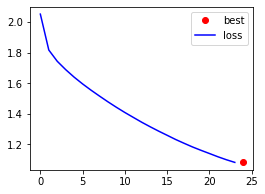

Best epoch so far:  24  smallest loss: 1.08070870303393
Time taken for the epoch 242.787 sec

Epoch 25 Batch 600 Loss: 0.8285
Epoch 25 Batch 1200 Loss: 0.7327
Epoch 25 Batch 1800 Loss: 0.7804
Epoch 25 Batch 2400 Loss: 1.6250
Epoch 25 Batch 3000 Loss: 1.0572
Epoch 25 Batch 3600 Loss: 0.8498

*** Epoch 25 Loss 1.0631 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine just a half me 
%
Greedy| Q: Are you my friend ?  A: i am not sure i am not sure i am not sure i am not sure i am 
%
Greedy| Q: What are you doing ?  A: i am not interested 
%
Greedy| Q: What your favorite restaurant ?  A: no thanks i am a dentist 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: what 
####################
check point saved!
Best epoch so far:  25  smallest loss: 1.0630541443328476
Time taken for the epoch 242.785 sec

Epoch 26 Batch 600 Loss: 0.8961
Epoch 26 Batch 1200 Loss: 0.6840
Epoch 26 Batch 1800 Loss: 0.7567
Epoch 26 Bat

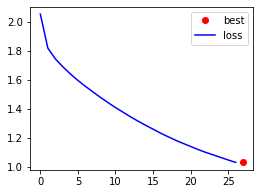

Best epoch so far:  27  smallest loss: 1.0289742001023452
Time taken for the epoch 242.918 sec

Epoch 28 Batch 600 Loss: 0.8802
Epoch 28 Batch 1200 Loss: 0.5904
Epoch 28 Batch 1800 Loss: 0.8257
Epoch 28 Batch 2400 Loss: 1.5336
Epoch 28 Batch 3000 Loss: 1.0227
Epoch 28 Batch 3600 Loss: 0.9198

*** Epoch 28 Loss 1.0130 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: i am fine i am a team player 
%
Greedy| Q: Are you my friend ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not interested 
%
Greedy| Q: What your favorite restaurant ?  A: no thanks i am a dentist 
%
Greedy| Q: Who are you ?  A: i am not you a little 
%
Greedy| Q: Do you want to go out ?  A: what 
####################
check point saved!
Best epoch so far:  28  smallest loss: 1.0129913575709477
Time taken for the epoch 243.061 sec

Epoch 29 Batch 600 Loss: 0.7587
Epoch 29 Batch 1200 Loss: 0.6778
Epoch 29 Batch 1800 Loss: 0.7773
Epoch 29 Batch 2400 Loss: 1.5091
Epoch 29 Batch 

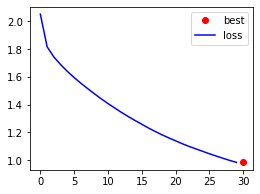

Best epoch so far:  30  smallest loss: 0.983342670712774
Time taken for the epoch 242.969 sec

Epoch 31 Batch 600 Loss: 0.8782
Epoch 31 Batch 1200 Loss: 0.5167
Epoch 31 Batch 1800 Loss: 0.8746
Epoch 31 Batch 2400 Loss: 1.4389
Epoch 31 Batch 3000 Loss: 0.9124
Epoch 31 Batch 3600 Loss: 0.7446

*** Epoch 31 Loss 0.9708 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not interested 
%
Greedy| Q: What your favorite restaurant ?  A: no really 
%
Greedy| Q: Who are you ?  A: i am not you 
%
Greedy| Q: Do you want to go out ?  A: no i do not know what i live here 
####################
check point saved!
Best epoch so far:  31  smallest loss: 0.9707853860931862
Time taken for the epoch 242.537 sec

Epoch 32 Batch 600 Loss: 0.8130
Epoch 32 Batch 1200 Loss: 0.5691
Epoch 32 Batch 1800 Loss: 0.7965
Epoch 32 Batch 2400 Loss: 1.4523
Epoch 32 Batch 3000 Loss: 0.933

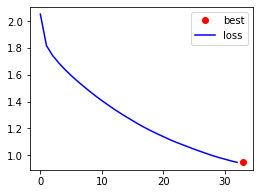

Best epoch so far:  33  smallest loss: 0.9467632495923536
Time taken for the epoch 242.786 sec

Epoch 34 Batch 600 Loss: 0.8290
Epoch 34 Batch 1200 Loss: 0.5736
Epoch 34 Batch 1800 Loss: 0.7188
Epoch 34 Batch 2400 Loss: 1.3000
Epoch 34 Batch 3000 Loss: 0.9464
Epoch 34 Batch 3600 Loss: 0.6779

*** Epoch 34 Loss 0.9341 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not interested 
%
Greedy| Q: What your favorite restaurant ?  A: yeah i am not sure that is not a gracious thing big time 
%
Greedy| Q: Who are you ?  A: i am not taking you 
%
Greedy| Q: Do you want to go out ?  A: no no no no no no no no no no no no no no no no no no 
####################
check point saved!
Best epoch so far:  34  smallest loss: 0.9341039856109492
Time taken for the epoch 242.969 sec

Epoch 35 Batch 600 Loss: 0.8524
Epoch 35 Batch 1200 Loss: 0.4632
Epoch 35 Batch 1800 Loss: 

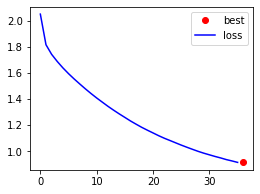

Best epoch so far:  36  smallest loss: 0.9126883873898487
Time taken for the epoch 242.813 sec

Epoch 37 Batch 600 Loss: 0.7171
Epoch 37 Batch 1200 Loss: 0.5781
Epoch 37 Batch 1800 Loss: 0.7365
Epoch 37 Batch 2400 Loss: 1.3637
Epoch 37 Batch 3000 Loss: 0.8678
Epoch 37 Batch 3600 Loss: 0.7208

*** Epoch 37 Loss 0.9002 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am late 
%
Greedy| Q: What are you doing ?  A: i am a dentist 
%
Greedy| Q: What your favorite restaurant ?  A: yeah i am not sure you are a great south america 
%
Greedy| Q: Who are you ?  A: i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: no i do not know what i said 
####################
check point saved!
Best epoch so far:  37  smallest loss: 0.900172910920587
Time taken for the epoch 242.431 sec

Epoch 38 Batch 600 Loss: 0.7632
Epoch 38 Batch 1200 Loss: 0.5436
Epoch 38 Batch 1800 Loss: 0.6957
Epoch 38 Batch 2400 Loss: 1.2587


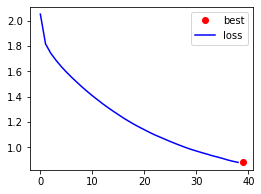

Best epoch so far:  39  smallest loss: 0.8810316218689287
Time taken for the epoch 242.516 sec

Epoch 40 Batch 600 Loss: 0.7838
Epoch 40 Batch 1200 Loss: 0.4899
Epoch 40 Batch 1800 Loss: 0.7580
Epoch 40 Batch 2400 Loss: 1.3334
Epoch 40 Batch 3000 Loss: 0.8406
Epoch 40 Batch 3600 Loss: 0.7506

*** Epoch 40 Loss 0.8721 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am late 
%
Greedy| Q: What are you doing ?  A: i am a child 
%
Greedy| Q: What your favorite restaurant ?  A: freezing and i will have a phone 
%
Greedy| Q: Who are you ?  A: i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: what 
####################
check point saved!
Best epoch so far:  40  smallest loss: 0.8720996527416389
Time taken for the epoch 242.676 sec

Epoch 41 Batch 600 Loss: 0.6380
Epoch 41 Batch 1200 Loss: 0.5639
Epoch 41 Batch 1800 Loss: 0.6964
Epoch 41 Batch 2400 Loss: 1.3067
Epoch 41 Batch 3000 Loss: 0.8300
Epoch

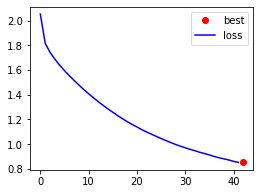

Best epoch so far:  42  smallest loss: 0.8525865625216833
Time taken for the epoch 242.519 sec

Epoch 43 Batch 600 Loss: 0.7674
Epoch 43 Batch 1200 Loss: 0.4390
Epoch 43 Batch 1800 Loss: 0.7857
Epoch 43 Batch 2400 Loss: 1.2551
Epoch 43 Batch 3000 Loss: 0.7990
Epoch 43 Batch 3600 Loss: 0.6435

*** Epoch 43 Loss 0.8433 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am just trying to fear you would be a little surprise 
%
Greedy| Q: What your favorite restaurant ?  A: freezing the door 
%
Greedy| Q: Who are you ?  A: i am a problem once 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  43  smallest loss: 0.8433029848173397
Time taken for the epoch 242.660 sec

Epoch 44 Batch 600 Loss: 0.7279
Epoch 44 Batch 1200 Loss: 0.4676
Epoch 44 Batch 1800 Loss: 0.7302
Epoch 44 Batch 2400 Loss: 1.2540

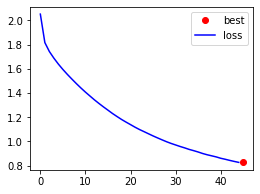

Best epoch so far:  45  smallest loss: 0.8268338938471412
Time taken for the epoch 242.496 sec

Epoch 46 Batch 600 Loss: 0.7051
Epoch 46 Batch 1200 Loss: 0.4814
Epoch 46 Batch 1800 Loss: 0.6483
Epoch 46 Batch 2400 Loss: 1.1215
Epoch 46 Batch 3000 Loss: 0.8122
Epoch 46 Batch 3600 Loss: 0.5702

*** Epoch 46 Loss 0.8186 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am not 
%
Greedy| Q: What are you doing ?  A: i am not interested who i am not interested who i am not interested who i am not 
%
Greedy| Q: What your favorite restaurant ?  A: it is great 
%
Greedy| Q: Who are you ?  A: i am fine i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  46  smallest loss: 0.81858996355034
Time taken for the epoch 242.595 sec

Epoch 47 Batch 600 Loss: 0.7394
Epoch 47 Batch 1200 Loss: 0.4075
Epoch 47 Batch 1800 Loss: 0.7854
Epoch 47 Ba

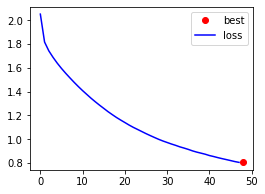

Best epoch so far:  48  smallest loss: 0.8032975314624965
Time taken for the epoch 242.677 sec

Epoch 49 Batch 600 Loss: 0.6164
Epoch 49 Batch 1200 Loss: 0.5130
Epoch 49 Batch 1800 Loss: 0.6267
Epoch 49 Batch 2400 Loss: 1.1727
Epoch 49 Batch 3000 Loss: 0.7410
Epoch 49 Batch 3600 Loss: 0.6035

*** Epoch 49 Loss 0.7964 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am with me 
%
Greedy| Q: What are you doing ?  A: i am telling you i am a child 
%
Greedy| Q: What your favorite restaurant ?  A: it is great 
%
Greedy| Q: Who are you ?  A: i am a problem where is this 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  49  smallest loss: 0.7963547358538023
Time taken for the epoch 242.364 sec

Epoch 50 Batch 600 Loss: 0.6844
Epoch 50 Batch 1200 Loss: 0.5035
Epoch 50 Batch 1800 Loss: 0.6099
Epoch 50 Batch 2400 Loss: 1.1024
Epoch 50 Batch 300

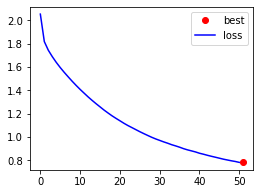

Best epoch so far:  51  smallest loss: 0.7826651076359977
Time taken for the epoch 242.631 sec

Epoch 52 Batch 600 Loss: 0.6708
Epoch 52 Batch 1200 Loss: 0.4341
Epoch 52 Batch 1800 Loss: 0.6815
Epoch 52 Batch 2400 Loss: 1.1468
Epoch 52 Batch 3000 Loss: 0.7676
Epoch 52 Batch 3600 Loss: 0.6282

*** Epoch 52 Loss 0.7781 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: i am a free question 
%
Greedy| Q: Are you my friend ?  A: that is up around 
%
Greedy| Q: What are you doing ?  A: i am a honest man 
%
Greedy| Q: What your favorite restaurant ?  A: it is the most important part 
%
Greedy| Q: Who are you ?  A: i am fine 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  52  smallest loss: 0.7780615356343672
Time taken for the epoch 242.610 sec

Epoch 53 Batch 600 Loss: 0.5640
Epoch 53 Batch 1200 Loss: 0.5031
Epoch 53 Batch 1800 Loss: 0.6103
Epoch 53 Batch 2400 Loss: 1.1387
Epoch 53 B

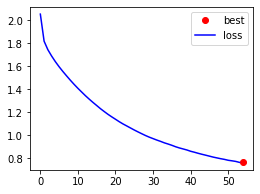

Best epoch so far:  54  smallest loss: 0.7643807840254649
Time taken for the epoch 242.677 sec

Epoch 55 Batch 600 Loss: 0.7101
Epoch 55 Batch 1200 Loss: 0.3880
Epoch 55 Batch 1800 Loss: 0.7120
Epoch 55 Batch 2400 Loss: 1.1259
Epoch 55 Batch 3000 Loss: 0.7217
Epoch 55 Batch 3600 Loss: 0.5328

*** Epoch 55 Loss 0.7603 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: that is up around 
%
Greedy| Q: What are you doing ?  A: i am not interested 
%
Greedy| Q: What your favorite restaurant ?  A: you know what i think i was a good idea good morning i will get some water 
%
Greedy| Q: Who are you ?  A: i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: i do not know i am having a message right 
####################
check point saved!
Best epoch so far:  55  smallest loss: 0.7603283071398834
Time taken for the epoch 242.775 sec

Epoch 56 Batch 600 Loss: 0.6505
Epoch 56 Batch 1200 Loss: 0.4085
Epoch 56 Batc

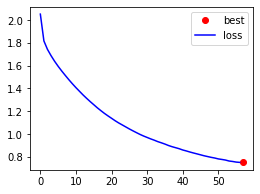

Best epoch so far:  57  smallest loss: 0.7522534389744657
Time taken for the epoch 242.730 sec

Epoch 58 Batch 600 Loss: 0.6243
Epoch 58 Batch 1200 Loss: 0.4555
Epoch 58 Batch 1800 Loss: 0.5798
Epoch 58 Batch 2400 Loss: 1.0137
Epoch 58 Batch 3000 Loss: 0.7364
Epoch 58 Batch 3600 Loss: 0.5205

*** Epoch 58 Loss 0.7456 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: oh yes i am 
%
Greedy| Q: What are you doing ?  A: i am telling you about me 
%
Greedy| Q: What your favorite restaurant ?  A: it is great 
%
Greedy| Q: Who are you ?  A: i am a problem answer 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  58  smallest loss: 0.7456484288266723
Time taken for the epoch 242.287 sec

Epoch 59 Batch 600 Loss: 0.6708
Epoch 59 Batch 1200 Loss: 0.3605
Epoch 59 Batch 1800 Loss: 0.6887
Epoch 59 Batch 2400 Loss: 1.0837
Epoch 59 Batch 3000 Loss: 0.7041
E

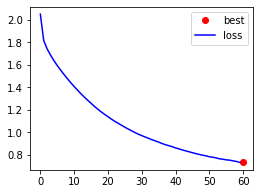

Best epoch so far:  60  smallest loss: 0.7324930911523383
Time taken for the epoch 242.583 sec

Epoch 61 Batch 600 Loss: 0.5499
Epoch 61 Batch 1200 Loss: 0.4640
Epoch 61 Batch 1800 Loss: 0.5856
Epoch 61 Batch 2400 Loss: 1.1275
Epoch 61 Batch 3000 Loss: 0.7292
Epoch 61 Batch 3600 Loss: 0.5688

*** Epoch 61 Loss 0.7296 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: i am okay 
%
Greedy| Q: Are you my friend ?  A: oh yes i am right 
%
Greedy| Q: What are you doing ?  A: i am just kidding 
%
Greedy| Q: What your favorite restaurant ?  A: it is coming 
%
Greedy| Q: Who are you ?  A: i am a lawyer and powerful wizard of oz 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  61  smallest loss: 0.7296033822725854
Time taken for the epoch 242.333 sec

Epoch 62 Batch 600 Loss: 0.6387
Epoch 62 Batch 1200 Loss: 0.4312
Epoch 62 Batch 1800 Loss: 0.5474
Epoch 62 Batch 2400 Loss: 0.9480
Epoch 62

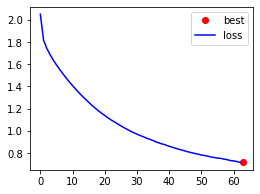

Best epoch so far:  63  smallest loss: 0.7162930766245142
Time taken for the epoch 242.454 sec

Epoch 64 Batch 600 Loss: 0.6415
Epoch 64 Batch 1200 Loss: 0.3809
Epoch 64 Batch 1800 Loss: 0.6485
Epoch 64 Batch 2400 Loss: 1.0552
Epoch 64 Batch 3000 Loss: 0.6718
Epoch 64 Batch 3600 Loss: 0.5995

*** Epoch 64 Loss 0.7136 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: i am fine i am a free and my secret is absolutely 
%
Greedy| Q: Are you my friend ?  A: oh yes i am alone 
%
Greedy| Q: What are you doing ?  A: i am telling you about me 
%
Greedy| Q: What your favorite restaurant ?  A: oh that thing to see you 
%
Greedy| Q: Who are you ?  A: i am okay whatever i am a lawyer and you are here i am a lawyer and you 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  64  smallest loss: 0.7135537280131141
Time taken for the epoch 242.420 sec

Epoch 65 Batch 600 Loss: 0.5721
Epoch 65 Batch 

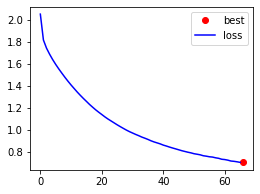

Best epoch so far:  66  smallest loss: 0.7039372435947474
Time taken for the epoch 242.592 sec

Epoch 67 Batch 600 Loss: 0.6685
Epoch 67 Batch 1200 Loss: 0.3337
Epoch 67 Batch 1800 Loss: 0.6548
Epoch 67 Batch 2400 Loss: 1.0180
Epoch 67 Batch 3000 Loss: 0.6829
Epoch 67 Batch 3600 Loss: 0.5007

*** Epoch 67 Loss 0.7001 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am 
%
Greedy| Q: What are you doing ?  A: i am just fine i am just fine i am just fine i am just fine i am 
%
Greedy| Q: What your favorite restaurant ?  A: it is great 
%
Greedy| Q: Who are you ?  A: who 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  67  smallest loss: 0.7001483545613031
Time taken for the epoch 242.418 sec

Epoch 68 Batch 600 Loss: 0.6197
Epoch 68 Batch 1200 Loss: 0.3972
Epoch 68 Batch 1800 Loss: 0.6803
Epoch 68 Batch 2400 Loss: 1.0468
Epoch 68 Batch 3

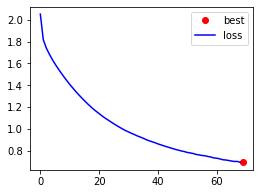

Best epoch so far:  69  smallest loss: 0.6915799198367679
Time taken for the epoch 242.436 sec

Epoch 70 Batch 600 Loss: 0.5786
Epoch 70 Batch 1200 Loss: 0.3820
Epoch 70 Batch 1800 Loss: 0.5261
Epoch 70 Batch 2400 Loss: 0.9257
Epoch 70 Batch 3000 Loss: 0.6713
Epoch 70 Batch 3600 Loss: 0.4895

*** Epoch 70 Loss 0.6894 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: i am a private investigator 
%
Greedy| Q: Are you my friend ?  A: hi would you 
%
Greedy| Q: What are you doing ?  A: i am telling you need to disturb you 
%
Greedy| Q: What your favorite restaurant ?  A: it is got no money and sleep 
%
Greedy| Q: Who are you ?  A: i am a lawyer and you are here i am a lawyer and you are here i am 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  70  smallest loss: 0.6894065736235429
Time taken for the epoch 242.645 sec

Epoch 71 Batch 600 Loss: 0.6333
Epoch 71 Batch 1200 Loss: 0.3391

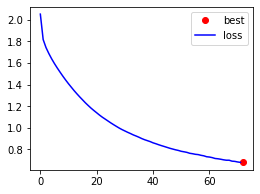

Best epoch so far:  72  smallest loss: 0.6800996185904108
Time taken for the epoch 242.643 sec

Epoch 73 Batch 600 Loss: 0.5169
Epoch 73 Batch 1200 Loss: 0.4034
Epoch 73 Batch 1800 Loss: 0.5079
Epoch 73 Batch 2400 Loss: 1.0267
Epoch 73 Batch 3000 Loss: 0.6227
Epoch 73 Batch 3600 Loss: 0.5369

*** Epoch 73 Loss 0.6774 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: others who you are taking day 
%
Greedy| Q: Are you my friend ?  A: that is that i have to 
%
Greedy| Q: What are you doing ?  A: i am not taking a little trouble 
%
Greedy| Q: What your favorite restaurant ?  A: great thank you 
%
Greedy| Q: Who are you ?  A: what do you mean i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: yeah 
####################
check point saved!
Best epoch so far:  73  smallest loss: 0.6774443606022759
Time taken for the epoch 242.473 sec

Epoch 74 Batch 600 Loss: 0.5914
Epoch 74 Batch 1200 Loss: 0.3669
Epoch 74 Batch 1800 Loss: 0.5004
Epoch 74 Batch 2

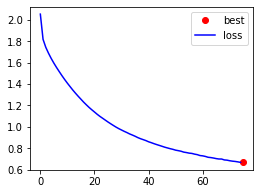

Best epoch so far:  75  smallest loss: 0.6686186397403205
Time taken for the epoch 242.561 sec

Epoch 76 Batch 600 Loss: 0.5929
Epoch 76 Batch 1200 Loss: 0.3785
Epoch 76 Batch 1800 Loss: 0.6333
Epoch 76 Batch 2400 Loss: 1.0004
Epoch 76 Batch 3000 Loss: 0.6080
Epoch 76 Batch 3600 Loss: 0.5455

*** Epoch 76 Loss 0.6657 ***

####################
Greedy| Q: Hello ?  A: god i have been calling you 
%
Greedy| Q: How are you ?  A: i am okay 
%
Greedy| Q: Are you my friend ?  A: that is up around 
%
Greedy| Q: What are you doing ?  A: i am okay 
%
Greedy| Q: What your favorite restaurant ?  A: oh that is your name 
%
Greedy| Q: Who are you ?  A: who is it 
%
Greedy| Q: Do you want to go out ?  A: yeah 
####################
check point saved!
Best epoch so far:  76  smallest loss: 0.6657479037650916
Time taken for the epoch 242.587 sec

Epoch 77 Batch 600 Loss: 0.5090
Epoch 77 Batch 1200 Loss: 0.4224
Epoch 77 Batch 1800 Loss: 0.5147
Epoch 77 Batch 2400 Loss: 0.9599
Epoch 77 Batch 3000 Loss: 0.5

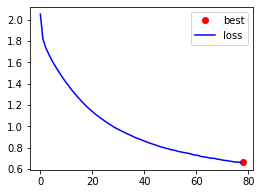

Best epoch so far:  78  smallest loss: 0.6620426310322994
Time taken for the epoch 242.513 sec

Epoch 79 Batch 600 Loss: 0.5918
Epoch 79 Batch 1200 Loss: 0.3412
Epoch 79 Batch 1800 Loss: 0.5883
Epoch 79 Batch 2400 Loss: 0.9383
Epoch 79 Batch 3000 Loss: 0.6409
Epoch 79 Batch 3600 Loss: 0.4651

*** Epoch 79 Loss 0.6551 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: i am okay 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am not taking a phone remember you are taking me beg me 
%
Greedy| Q: What your favorite restaurant ?  A: it is got anywhere alone 
%
Greedy| Q: Who are you ?  A: well no i am a long second tomorrow 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  79  smallest loss: 0.6550585693562656
Time taken for the epoch 242.271 sec

Epoch 80 Batch 600 Loss: 0.5795
Epoch 80 Batch 1200 Loss: 0.3765
Epoch 80 Batch 1800 Loss: 0.6026
Epoch 8

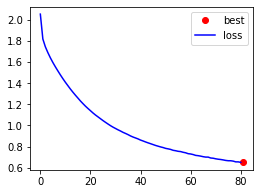

Best epoch so far:  81  smallest loss: 0.6501115200223772
Time taken for the epoch 242.360 sec

Epoch 82 Batch 600 Loss: 0.5318
Epoch 82 Batch 1200 Loss: 0.3536
Epoch 82 Batch 1800 Loss: 0.4839
Epoch 82 Batch 2400 Loss: 0.9045
Epoch 82 Batch 3000 Loss: 0.6468
Epoch 82 Batch 3600 Loss: 0.4317

*** Epoch 82 Loss 0.6462 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: i am okay 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am talking to me if you were talking about it 
%
Greedy| Q: What your favorite restaurant ?  A: it is got no need to see 
%
Greedy| Q: Who are you ?  A: well i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  82  smallest loss: 0.6462434191125451
Time taken for the epoch 242.481 sec

Epoch 83 Batch 600 Loss: 0.6048
Epoch 83 Batch 1200 Loss: 0.3270
Epoch 83 Batch 1800 Loss: 0.6032
Epoch 83 Batch 2400 Loss: 0.9355
E

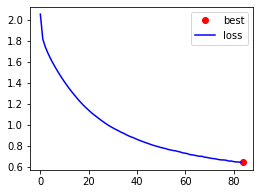

Best epoch so far:  84  smallest loss: 0.6423063381426936
Time taken for the epoch 242.294 sec

Epoch 85 Batch 600 Loss: 0.4921
Epoch 85 Batch 1200 Loss: 0.4176
Epoch 85 Batch 1800 Loss: 0.5141
Epoch 85 Batch 2400 Loss: 0.8911
Epoch 85 Batch 3000 Loss: 0.5740
Epoch 85 Batch 3600 Loss: 0.4910

*** Epoch 85 Loss 0.6374 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: those are good but i am a free man 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am telling you i was alone jake 
%
Greedy| Q: What your favorite restaurant ?  A: it is the most important good 
%
Greedy| Q: Who are you ?  A: i am a little 
%
Greedy| Q: Do you want to go out ?  A: i have a better chance 
####################
check point saved!
Best epoch so far:  85  smallest loss: 0.6374348416250347
Time taken for the epoch 241.996 sec

Epoch 86 Batch 600 Loss: 0.5385
Epoch 86 Batch 1200 Loss: 0.3498
Epoch 86 Batch 1800 Loss: 0.5033
Epoch 86 Batch

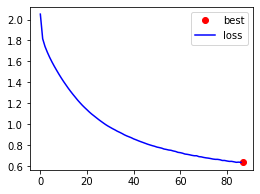

Best epoch so far:  87  smallest loss: 0.6367121772437899
Time taken for the epoch 242.434 sec

Epoch 88 Batch 600 Loss: 0.5188
Epoch 88 Batch 1200 Loss: 0.3258
Epoch 88 Batch 1800 Loss: 0.5682
Epoch 88 Batch 2400 Loss: 0.9422
Epoch 88 Batch 3000 Loss: 0.6320
Epoch 88 Batch 3600 Loss: 0.5472

*** Epoch 88 Loss 0.6304 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: i am okay 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am just fine he loves you 
%
Greedy| Q: What your favorite restaurant ?  A: oh that is great 
%
Greedy| Q: Who are you ?  A: i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: me no way 
####################
check point saved!
Best epoch so far:  88  smallest loss: 0.6303928448298293
Time taken for the epoch 242.318 sec

Epoch 89 Batch 600 Loss: 0.5256
Epoch 89 Batch 1200 Loss: 0.4232
Epoch 89 Batch 1800 Loss: 0.4961
Epoch 89 Batch 2400 Loss: 0.9045
Epoch 89 Batch 3000 Loss: 0.5686
Epoch

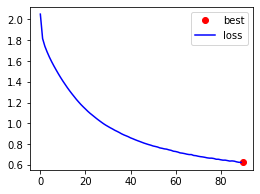

Best epoch so far:  90  smallest loss: 0.6248683415946781
Time taken for the epoch 242.491 sec

Epoch 91 Batch 600 Loss: 0.5466
Epoch 91 Batch 1200 Loss: 0.2859
Epoch 91 Batch 1800 Loss: 0.5954
Epoch 91 Batch 2400 Loss: 0.8726
Epoch 91 Batch 3000 Loss: 0.6087
Epoch 91 Batch 3600 Loss: 0.4110

*** Epoch 91 Loss 0.6225 ***

####################
Greedy| Q: Hello ?  A: god you are just doing here 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: hi 
%
Greedy| Q: What are you doing ?  A: i am going to need you 
%
Greedy| Q: What your favorite restaurant ?  A: it is the light 
%
Greedy| Q: Who are you ?  A: i do not know 
%
Greedy| Q: Do you want to go out ?  A: no i have nothing to do 
####################
check point saved!
Best epoch so far:  91  smallest loss: 0.6224882584825145
Time taken for the epoch 242.352 sec

Epoch 92 Batch 600 Loss: 0.5281
Epoch 92 Batch 1200 Loss: 0.3009
Epoch 92 Batch 1800 Loss: 0.5471
Epoch 92 Batch 2400 Loss: 0.9027
Epoch 92 Batch 300

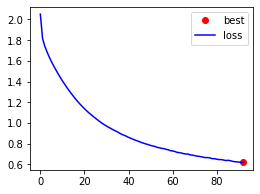

Best epoch so far:  92  smallest loss: 0.6193077220805578
Time taken for the epoch 242.518 sec

Epoch 94 Batch 600 Loss: 0.5414
Epoch 94 Batch 1200 Loss: 0.3015
Epoch 94 Batch 1800 Loss: 0.4481
Epoch 94 Batch 2400 Loss: 0.7988
Epoch 94 Batch 3000 Loss: 0.6216
Epoch 94 Batch 3600 Loss: 0.4004

*** Epoch 94 Loss 0.6151 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: pouring it out 
%
Greedy| Q: What your favorite restaurant ?  A: it is got no money and white fat accent 
%
Greedy| Q: Who are you ?  A: we hung out last night remember 
%
Greedy| Q: Do you want to go out ?  A: want to come back i have to access the same way it is no one that is true 
####################
check point saved!
Best epoch so far:  94  smallest loss: 0.6150512864713433
Time taken for the epoch 242.391 sec

Epoch 95 Batch 600 Loss: 0.5934
Epoch 95 Batch 1200 Loss: 0.2531
Epoch 95 Batch 18

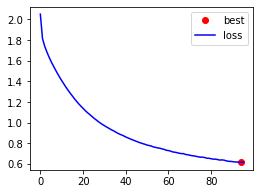

Best epoch so far:  94  smallest loss: 0.6150512864713433
Time taken for the epoch 242.342 sec

Epoch 97 Batch 600 Loss: 0.4955
Epoch 97 Batch 1200 Loss: 0.3876
Epoch 97 Batch 1800 Loss: 0.4743
Epoch 97 Batch 2400 Loss: 0.8831
Epoch 97 Batch 3000 Loss: 0.5579
Epoch 97 Batch 3600 Loss: 0.4634

*** Epoch 97 Loss 0.6133 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine eh i am okay 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am telling you i was alone jake 
%
Greedy| Q: What your favorite restaurant ?  A: it is got no real bad news at the kitchen 
%
Greedy| Q: Who are you ?  A: we hung out last night remember 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  97  smallest loss: 0.61327427068155
Time taken for the epoch 242.512 sec

Epoch 98 Batch 600 Loss: 0.5332
Epoch 98 Batch 1200 Loss: 0.3928
Epoch 98 Batch 1800 Loss: 0.4527
Epoch 98 Batch 2

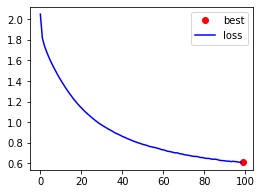

Best epoch so far:  99  smallest loss: 0.6074464042551346
Time taken for the epoch 242.569 sec

Epoch 100 Batch 600 Loss: 0.5335
Epoch 100 Batch 1200 Loss: 0.3009
Epoch 100 Batch 1800 Loss: 0.5772
Epoch 100 Batch 2400 Loss: 0.9283
Epoch 100 Batch 3000 Loss: 0.5658
Epoch 100 Batch 3600 Loss: 0.4874

*** Epoch 100 Loss 0.6026 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: look i am 
%
Greedy| Q: Who are you ?  A: well i am the those room 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  100  smallest loss: 0.602581954816299
Time taken for the epoch 242.355 sec

Epoch 101 Batch 600 Loss: 0.4481
Epoch 101 Batch 1200 Loss: 0.3773
Epoch 101 Batch 1800 Loss: 0.4955
Epoch 101 Batch 2400 Loss: 0.8548
Epoch 101 Batch 3000 Loss: 0.5532
Epoch 101 B

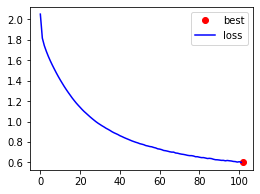

Best epoch so far:  102  smallest loss: 0.5995397850966209
Time taken for the epoch 242.398 sec

Epoch 103 Batch 600 Loss: 0.5212
Epoch 103 Batch 1200 Loss: 0.2940
Epoch 103 Batch 1800 Loss: 0.5879
Epoch 103 Batch 2400 Loss: 0.8771
Epoch 103 Batch 3000 Loss: 0.5217
Epoch 103 Batch 3600 Loss: 0.4086

*** Epoch 103 Loss 0.5955 ***

####################
Greedy| Q: Hello ?  A: god i have been calling you 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am telling you i was alone jake 
%
Greedy| Q: What your favorite restaurant ?  A: oh that is the most important place 
%
Greedy| Q: Who are you ?  A: i am the great you yes i do not know 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  103  smallest loss: 0.5954732818137664
Time taken for the epoch 242.398 sec

Epoch 104 Batch 600 Loss: 0.4845
Epoch 104 Batch 1200 Loss: 0.3008
Epoch 104 Batch 1800 Loss: 0

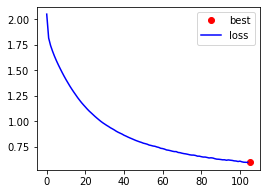

Best epoch so far:  105  smallest loss: 0.593951451589821
Time taken for the epoch 242.453 sec

Epoch 106 Batch 600 Loss: 0.5099
Epoch 106 Batch 1200 Loss: 0.3169
Epoch 106 Batch 1800 Loss: 0.4559
Epoch 106 Batch 2400 Loss: 0.7858
Epoch 106 Batch 3000 Loss: 0.5306
Epoch 106 Batch 3600 Loss: 0.4033

*** Epoch 106 Loss 0.5930 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine eh i am a free and you are like you do not look at whacking 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am telling walter miss 
%
Greedy| Q: What your favorite restaurant ?  A: it is tv blowing up 
%
Greedy| Q: Who are you ?  A: i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  106  smallest loss: 0.5929554418626839
Time taken for the epoch 242.431 sec

Epoch 107 Batch 600 Loss: 0.5377
Epoch 107 Batch 1200 Loss: 0.2521
Epoch 107 Batch 1800 Loss: 0.5362
E

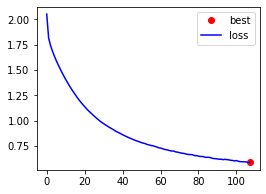

Best epoch so far:  107  smallest loss: 0.5881475723355537
Time taken for the epoch 242.577 sec

Epoch 109 Batch 600 Loss: 0.4539
Epoch 109 Batch 1200 Loss: 0.3928
Epoch 109 Batch 1800 Loss: 0.4670
Epoch 109 Batch 2400 Loss: 0.8457
Epoch 109 Batch 3000 Loss: 0.5089
Epoch 109 Batch 3600 Loss: 0.4309

*** Epoch 109 Loss 0.5876 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine eh i am a free and you cannot feel important 
%
Greedy| Q: Are you my friend ?  A: hi 
%
Greedy| Q: What are you doing ?  A: i am stealing an unfortunate accident 
%
Greedy| Q: What your favorite restaurant ?  A: look big boys 
%
Greedy| Q: Who are you ?  A: well i i am a problem 
%
Greedy| Q: Do you want to go out ?  A: no i have nothing to do 
####################
check point saved!
Best epoch so far:  109  smallest loss: 0.5875722867662365
Time taken for the epoch 242.251 sec

Epoch 110 Batch 600 Loss: 0.5163
Epoch 110 Batch 1200 Loss: 0.3368
Epoch 110 Batch 1800 Loss

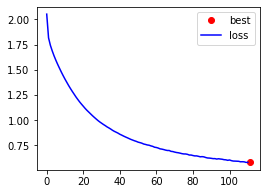

Best epoch so far:  111  smallest loss: 0.5821307899883778
Time taken for the epoch 242.704 sec

Epoch 112 Batch 600 Loss: 0.5214
Epoch 112 Batch 1200 Loss: 0.3165
Epoch 112 Batch 1800 Loss: 0.5284
Epoch 112 Batch 2400 Loss: 0.8887
Epoch 112 Batch 3000 Loss: 0.5609
Epoch 112 Batch 3600 Loss: 0.4656

*** Epoch 112 Loss 0.5795 ***

####################
Greedy| Q: Hello ?  A: i am so afraid to me with the door 
%
Greedy| Q: How are you ?  A: fine eh they are today besides 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am telling you i was trying to find out 
%
Greedy| Q: What your favorite restaurant ?  A: still straight to my bed 
%
Greedy| Q: Who are you ?  A: well i am the great you were saying 
%
Greedy| Q: Do you want to go out ?  A: me 
####################
check point saved!
Best epoch so far:  112  smallest loss: 0.5794748543965098
Time taken for the epoch 242.462 sec

Epoch 113 Batch 600 Loss: 0.4693
Epoch 113 Batch 1200 Loss: 0.3355
Epoch 113 

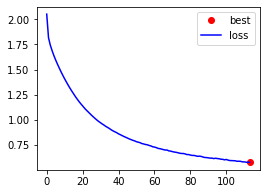

Best epoch so far:  113  smallest loss: 0.5771155059585762
Time taken for the epoch 242.367 sec

Epoch 115 Batch 600 Loss: 0.5000
Epoch 115 Batch 1200 Loss: 0.2605
Epoch 115 Batch 1800 Loss: 0.5508
Epoch 115 Batch 2400 Loss: 0.8393
Epoch 115 Batch 3000 Loss: 0.5403
Epoch 115 Batch 3600 Loss: 0.3875

*** Epoch 115 Loss 0.5744 ***

####################
Greedy| Q: Hello ?  A: i thought you are not 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am telling walter thinks every man 
%
Greedy| Q: What your favorite restaurant ?  A: it is got plenty 
%
Greedy| Q: Who are you ?  A: i am the great charlie 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  115  smallest loss: 0.5744317886136553
Time taken for the epoch 242.485 sec

Epoch 116 Batch 600 Loss: 0.4954
Epoch 116 Batch 1200 Loss: 0.2757
Epoch 116 Batch 1800 Loss: 0.5121
Epoch 116 Batch 2400 Loss: 0.8

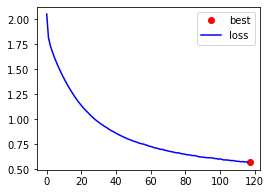

Best epoch so far:  117  smallest loss: 0.5704707882320289
Time taken for the epoch 242.252 sec

Epoch 118 Batch 600 Loss: 0.5268
Epoch 118 Batch 1200 Loss: 0.2970
Epoch 118 Batch 1800 Loss: 0.4405
Epoch 118 Batch 2400 Loss: 0.7669
Epoch 118 Batch 3000 Loss: 0.5354
Epoch 118 Batch 3600 Loss: 0.3455

*** Epoch 118 Loss 0.5673 ***

####################
Greedy| Q: Hello ?  A: i am so afraid 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am telling walter the lights 
%
Greedy| Q: What your favorite restaurant ?  A: i am not hungry and it 
%
Greedy| Q: Who are you ?  A: i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  118  smallest loss: 0.5673467639814044
Time taken for the epoch 242.364 sec

Epoch 119 Batch 600 Loss: 0.5308
Epoch 119 Batch 1200 Loss: 0.2386
Epoch 119 Batch 1800 Loss: 0.5061
Epoch 119 Batch 2400 Loss: 0.8187
Epoch 119 Ba

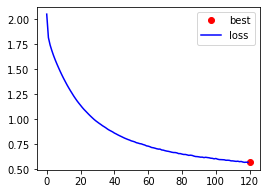

Best epoch so far:  120  smallest loss: 0.5670276126231613
Time taken for the epoch 242.665 sec

Epoch 121 Batch 600 Loss: 0.4197
Epoch 121 Batch 1200 Loss: 0.3941
Epoch 121 Batch 1800 Loss: 0.4864
Epoch 121 Batch 2400 Loss: 0.7928
Epoch 121 Batch 3000 Loss: 0.5059
Epoch 121 Batch 3600 Loss: 0.4258

*** Epoch 121 Loss 0.5654 ***

####################
Greedy| Q: Hello ?  A: i thought to condition 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am looking for a room upstairs 
%
Greedy| Q: What your favorite restaurant ?  A: i have got a ride 
%
Greedy| Q: Who are you ?  A: where is it 
%
Greedy| Q: Do you want to go out ?  A: i have it 
####################
check point saved!
Best epoch so far:  121  smallest loss: 0.5654196250845649
Time taken for the epoch 242.317 sec

Epoch 122 Batch 600 Loss: 0.5035
Epoch 122 Batch 1200 Loss: 0.2839
Epoch 122 Batch 1800 Loss: 0.4750
Epoch 122 Batch 2400 Loss: 0.7479
Epoch 122 Bat

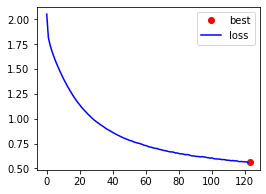

Best epoch so far:  123  smallest loss: 0.560099927577713
Time taken for the epoch 242.491 sec

Epoch 124 Batch 600 Loss: 0.5259
Epoch 124 Batch 1200 Loss: 0.3022
Epoch 124 Batch 1800 Loss: 0.4981
Epoch 124 Batch 2400 Loss: 0.8412
Epoch 124 Batch 3000 Loss: 0.5537
Epoch 124 Batch 3600 Loss: 0.4339

*** Epoch 124 Loss 0.5572 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am telling walter surely you wear it 
%
Greedy| Q: What your favorite restaurant ?  A: i am not a married person at the kitchen 
%
Greedy| Q: Who are you ?  A: where is this a little bit 
%
Greedy| Q: Do you want to go out ?  A: i am not going to kill me 
####################
check point saved!
Best epoch so far:  124  smallest loss: 0.5572212975189946
Time taken for the epoch 242.849 sec

Epoch 125 Batch 600 Loss: 0.4778
Epoch 125 Batch 1200 Loss: 0.3717
Epoch 125 Batch 1800 Loss: 0.4691
E

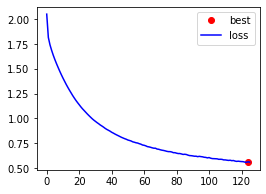

Best epoch so far:  124  smallest loss: 0.5572212975189946
Time taken for the epoch 242.306 sec

Epoch 127 Batch 600 Loss: 0.4957
Epoch 127 Batch 1200 Loss: 0.2715
Epoch 127 Batch 1800 Loss: 0.4941
Epoch 127 Batch 2400 Loss: 0.7738
Epoch 127 Batch 3000 Loss: 0.4836
Epoch 127 Batch 3600 Loss: 0.3744

*** Epoch 127 Loss 0.5561 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: i am clean something 
%
Greedy| Q: What are you doing ?  A: i am telling walter and i am third 
%
Greedy| Q: What your favorite restaurant ?  A: i have got a ride 
%
Greedy| Q: Who are you ?  A: i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: i have nothing to do 
####################
check point saved!
Best epoch so far:  127  smallest loss: 0.5561221903838814
Time taken for the epoch 242.280 sec

Epoch 128 Batch 600 Loss: 0.5281
Epoch 128 Batch 1200 Loss: 0.2835
Epoch 128 Batch 1800 Loss: 0.5146
Epoch 128 Batch 2400 Loss: 0.802

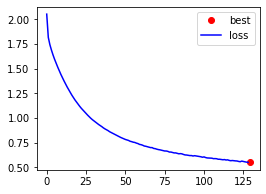

Best epoch so far:  129  smallest loss: 0.5504106007580488
Time taken for the epoch 242.266 sec

Epoch 130 Batch 600 Loss: 0.5008
Epoch 130 Batch 1200 Loss: 0.2949
Epoch 130 Batch 1800 Loss: 0.4491
Epoch 130 Batch 2400 Loss: 0.7365
Epoch 130 Batch 3000 Loss: 0.4958
Epoch 130 Batch 3600 Loss: 0.3327

*** Epoch 130 Loss 0.5539 ***

####################
Greedy| Q: Hello ?  A: i am so afraid i will call 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what about your head 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: i am not a married person at least 
%
Greedy| Q: Who are you ?  A: well i am a lawyer 
%
Greedy| Q: Do you want to go out ?  A: i have nothing to do something i am not going to die 
####################
Best epoch so far:  129  smallest loss: 0.5504106007580488
Time taken for the epoch 242.594 sec

Epoch 131 Batch 600 Loss: 0.4744
Epoch 131 Batch 1200 Loss: 0.2493
Epoch 131 Batch 1800 Loss: 0.5388


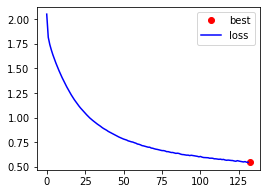

Best epoch so far:  132  smallest loss: 0.54591198957466
Time taken for the epoch 242.328 sec

Epoch 133 Batch 600 Loss: 0.4751
Epoch 133 Batch 1200 Loss: 0.3222
Epoch 133 Batch 1800 Loss: 0.4568
Epoch 133 Batch 2400 Loss: 0.7785
Epoch 133 Batch 3000 Loss: 0.4872
Epoch 133 Batch 3600 Loss: 0.4291

*** Epoch 133 Loss 0.5482 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you think that i am behind this room 
%
Greedy| Q: What are you doing ?  A: i am hungry 
%
Greedy| Q: What your favorite restaurant ?  A: i was wondering 
%
Greedy| Q: Who are you ?  A: well i am the great and powerful wizard of oz 
%
Greedy| Q: Do you want to go out ?  A: i have nothing to do something to see anybody 
####################
Best epoch so far:  132  smallest loss: 0.54591198957466
Time taken for the epoch 242.377 sec

Epoch 134 Batch 600 Loss: 0.5027
Epoch 134 Batch 1200 Loss: 0.3089
Epoch 134 Batch 1800 Loss: 0.4777

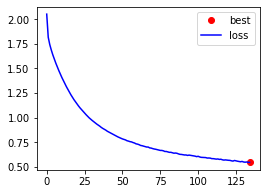

Best epoch so far:  134  smallest loss: 0.5440623685448758
Time taken for the epoch 242.746 sec

Epoch 136 Batch 600 Loss: 0.4684
Epoch 136 Batch 1200 Loss: 0.2923
Epoch 136 Batch 1800 Loss: 0.4633
Epoch 136 Batch 2400 Loss: 0.8176
Epoch 136 Batch 3000 Loss: 0.5150
Epoch 136 Batch 3600 Loss: 0.4315

*** Epoch 136 Loss 0.5392 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine why do not be great 
%
Greedy| Q: Are you my friend ?  A: what do you want me to know my own for an idea 
%
Greedy| Q: What are you doing ?  A: i got to work you are just there is nothing there is nothing there is nothing there is 
%
Greedy| Q: What your favorite restaurant ?  A: i am not a married person at me 
%
Greedy| Q: Who are you ?  A: well i am the great and powerful wizard of oz 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  136  smallest loss: 0.5391941245251353
Time taken for the epoch 243.1

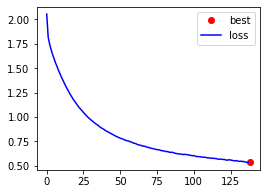

Best epoch so far:  138  smallest loss: 0.5354693368048328
Time taken for the epoch 242.290 sec

Epoch 139 Batch 600 Loss: 0.4389
Epoch 139 Batch 1200 Loss: 0.2631
Epoch 139 Batch 1800 Loss: 0.5147
Epoch 139 Batch 2400 Loss: 0.7432
Epoch 139 Batch 3000 Loss: 0.5156
Epoch 139 Batch 3600 Loss: 0.3735

*** Epoch 139 Loss 0.5369 ***

####################
Greedy| Q: Hello ?  A: mrs christian tom welles here 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you want me to you again today 
%
Greedy| Q: What are you doing ?  A: it is elevated same out 
%
Greedy| Q: What your favorite restaurant ?  A: i am not ok okay 
%
Greedy| Q: Who are you ?  A: well i could tell you i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything to see the water 
####################
Best epoch so far:  138  smallest loss: 0.5354693368048328
Time taken for the epoch 242.142 sec

Epoch 140 Batch 600 Loss: 0.4547
Epoch 140 Batch 1200 Loss: 0.2724
Epoch 140 B

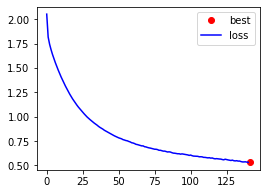

Best epoch so far:  141  smallest loss: 0.5308174177768527
Time taken for the epoch 242.250 sec

Epoch 142 Batch 600 Loss: 0.4924
Epoch 142 Batch 1200 Loss: 0.3261
Epoch 142 Batch 1800 Loss: 0.4641
Epoch 142 Batch 2400 Loss: 0.7367
Epoch 142 Batch 3000 Loss: 0.5107
Epoch 142 Batch 3600 Loss: 0.3458

*** Epoch 142 Loss 0.5303 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what 
%
Greedy| Q: What are you doing ?  A: i got to work 
%
Greedy| Q: What your favorite restaurant ?  A: look big client here to see the cards permission my wife back to the cards permission my wife 
%
Greedy| Q: Who are you ?  A: well i i know 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  142  smallest loss: 0.5303161942955523
Time taken for the epoch 242.098 sec

Epoch 143 Batch 600 Loss: 0.4489
Epoch 143 Batch 1200 Loss: 0.2269
Epoch 143 Batch 1800 Loss: 0.5

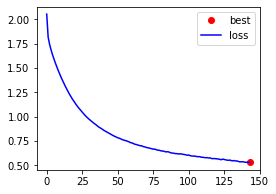

Best epoch so far:  143  smallest loss: 0.5295985441819318
Time taken for the epoch 242.385 sec

Epoch 145 Batch 600 Loss: 0.4024
Epoch 145 Batch 1200 Loss: 0.3200
Epoch 145 Batch 1800 Loss: 0.4148
Epoch 145 Batch 2400 Loss: 0.8119
Epoch 145 Batch 3000 Loss: 0.4678
Epoch 145 Batch 3600 Loss: 0.3961

*** Epoch 145 Loss 0.5295 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you want me to tell me this 
%
Greedy| Q: What are you doing ?  A: i got us out our food i was alone upstairs 
%
Greedy| Q: What your favorite restaurant ?  A: i have got no courthouse it is late 
%
Greedy| Q: Who are you ?  A: i am a long time ago 
%
Greedy| Q: Do you want to go out ?  A: no i do not know 
####################
check point saved!
Best epoch so far:  145  smallest loss: 0.5295392199751076
Time taken for the epoch 242.540 sec

Epoch 146 Batch 600 Loss: 0.4855
Epoch 146 Batch 1200 Loss: 0.2566
Epoch 146 Batch 18

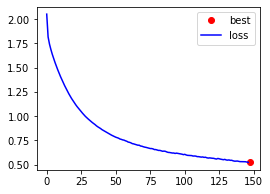

Best epoch so far:  147  smallest loss: 0.5228520842548744
Time taken for the epoch 242.404 sec

Epoch 148 Batch 600 Loss: 0.4543
Epoch 148 Batch 1200 Loss: 0.2795
Epoch 148 Batch 1800 Loss: 0.4984
Epoch 148 Batch 2400 Loss: 0.7996
Epoch 148 Batch 3000 Loss: 0.5410
Epoch 148 Batch 3600 Loss: 0.4509

*** Epoch 148 Loss 0.5241 ***

####################
Greedy| Q: Hello ?  A: god i have been calling you again 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you want me to the boat 
%
Greedy| Q: What are you doing ?  A: it is elevated 
%
Greedy| Q: What your favorite restaurant ?  A: i am a dog 
%
Greedy| Q: Who are you ?  A: i brought a little time 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything to see anybody 
####################
Best epoch so far:  147  smallest loss: 0.5228520842548744
Time taken for the epoch 242.507 sec

Epoch 149 Batch 600 Loss: 0.3918
Epoch 149 Batch 1200 Loss: 0.3076
Epoch 149 Batch 1800 Loss: 0.4581
Epoch 149 Ba

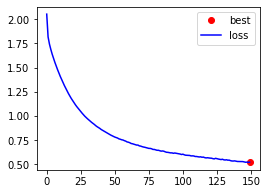

Best epoch so far:  149  smallest loss: 0.5213358103815396
Time taken for the epoch 242.536 sec

Epoch 151 Batch 600 Loss: 0.4576
Epoch 151 Batch 1200 Loss: 0.2217
Epoch 151 Batch 1800 Loss: 0.4778
Epoch 151 Batch 2400 Loss: 0.7858
Epoch 151 Batch 3000 Loss: 0.4420
Epoch 151 Batch 3600 Loss: 0.3461

*** Epoch 151 Loss 0.5185 ***

####################
Greedy| Q: Hello ?  A: mrs christian tom welles here 
%
Greedy| Q: How are you ?  A: fine why do not look better 
%
Greedy| Q: Are you my friend ?  A: what are you doing anything i love him 
%
Greedy| Q: What are you doing ?  A: it here 
%
Greedy| Q: What your favorite restaurant ?  A: i have got a vacation 
%
Greedy| Q: Who are you ?  A: i am agent to you you were married 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything would you just save the water will help you 
####################
check point saved!
Best epoch so far:  151  smallest loss: 0.5185328347796108
Time taken for the epoch 242.320 sec

Epoch 152 Batch 600 Loss

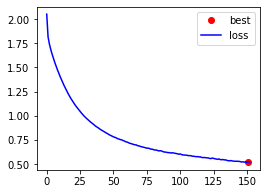

Best epoch so far:  151  smallest loss: 0.5185328347796108
Time taken for the epoch 242.375 sec

Epoch 154 Batch 600 Loss: 0.4596
Epoch 154 Batch 1200 Loss: 0.2561
Epoch 154 Batch 1800 Loss: 0.4125
Epoch 154 Batch 2400 Loss: 0.6524
Epoch 154 Batch 3000 Loss: 0.4590
Epoch 154 Batch 3600 Loss: 0.3107

*** Epoch 154 Loss 0.5139 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you want to see you 
%
Greedy| Q: What are you doing ?  A: i got a phone 
%
Greedy| Q: What your favorite restaurant ?  A: i was wondering we are okay 
%
Greedy| Q: Who are you ?  A: i am a messenger so 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything to ourselves i am not going to do 
####################
check point saved!
Best epoch so far:  154  smallest loss: 0.5138588936303081
Time taken for the epoch 242.313 sec

Epoch 155 Batch 600 Loss: 0.4379
Epoch 155 Batch 1200 Loss: 0.2158
Epoch 155 Batch 1800 Los

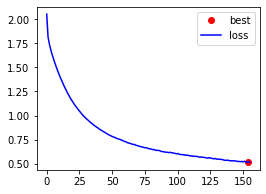

Best epoch so far:  154  smallest loss: 0.5138588936303081
Time taken for the epoch 242.479 sec

Epoch 157 Batch 600 Loss: 0.4074
Epoch 157 Batch 1200 Loss: 0.2856
Epoch 157 Batch 1800 Loss: 0.4351
Epoch 157 Batch 2400 Loss: 0.7447
Epoch 157 Batch 3000 Loss: 0.4570
Epoch 157 Batch 3600 Loss: 0.4010

*** Epoch 157 Loss 0.5151 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i got to go 
%
Greedy| Q: What your favorite restaurant ?  A: i am a very much pain and i thought you might need a ride 
%
Greedy| Q: Who are you ?  A: i am the great age 
%
Greedy| Q: Do you want to go out ?  A: i do not have to access the water will 
####################
Best epoch so far:  154  smallest loss: 0.5138588936303081
Time taken for the epoch 242.281 sec

Epoch 158 Batch 600 Loss: 0.4712
Epoch 158 Batch 1200 Loss: 0.2143
Epoch 158 Batch 1800 Loss: 0.4048
Epoch 158 Batch 2400 Loss

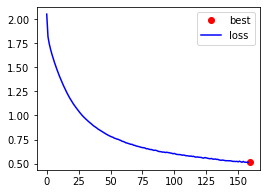

Best epoch so far:  159  smallest loss: 0.5129778732566611
Time taken for the epoch 242.391 sec

Epoch 160 Batch 600 Loss: 0.4554
Epoch 160 Batch 1200 Loss: 0.2245
Epoch 160 Batch 1800 Loss: 0.4574
Epoch 160 Batch 2400 Loss: 0.7249
Epoch 160 Batch 3000 Loss: 0.4876
Epoch 160 Batch 3600 Loss: 0.3769

*** Epoch 160 Loss 0.5076 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you want me to mom where the hell do you really beat the family 
%
Greedy| Q: What are you doing ?  A: it is elevated same out who you are going to kill you 
%
Greedy| Q: What your favorite restaurant ?  A: i was thinking 
%
Greedy| Q: Who are you ?  A: i am a little while 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  160  smallest loss: 0.5075590423236712
Time taken for the epoch 242.445 sec

Epoch 161 Batch 600 Loss: 0.3966
Epoch 161 Batch 1200 Loss: 0.3

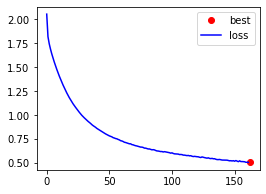

Best epoch so far:  162  smallest loss: 0.5064440115008326
Time taken for the epoch 242.174 sec

Epoch 163 Batch 600 Loss: 0.4843
Epoch 163 Batch 1200 Loss: 0.2383
Epoch 163 Batch 1800 Loss: 0.4716
Epoch 163 Batch 2400 Loss: 0.7407
Epoch 163 Batch 3000 Loss: 0.4533
Epoch 163 Batch 3600 Loss: 0.3269

*** Epoch 163 Loss 0.5062 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you want to see you 
%
Greedy| Q: What are you doing ?  A: it is all this all us what are you talking to me 
%
Greedy| Q: What your favorite restaurant ?  A: i am a fresh air 
%
Greedy| Q: Who are you ?  A: i am all what you should know for you 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  163  smallest loss: 0.5062062403509229
Time taken for the epoch 242.351 sec

Epoch 164 Batch 600 Loss: 0.4225
Epoch 164 Batch 1200 Loss: 0.2249
Epoch 164 Batch 1800 Loss

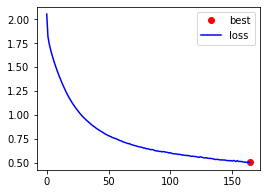

Best epoch so far:  164  smallest loss: 0.5048397169025812
Time taken for the epoch 242.273 sec

Epoch 166 Batch 600 Loss: 0.4415
Epoch 166 Batch 1200 Loss: 0.2992
Epoch 166 Batch 1800 Loss: 0.4033
Epoch 166 Batch 2400 Loss: 0.6886
Epoch 166 Batch 3000 Loss: 0.4597
Epoch 166 Batch 3600 Loss: 0.3214

*** Epoch 166 Loss 0.5045 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you want to see my room 
%
Greedy| Q: What are you doing ?  A: it can hear you and you are going to kill you 
%
Greedy| Q: What your favorite restaurant ?  A: honey why does not have a lot nice people like a fresh room 
%
Greedy| Q: Who are you ?  A: i was finally i am coming out 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  166  smallest loss: 0.5044981029805891
Time taken for the epoch 242.261 sec

Epoch 167 Batch 600 Loss: 0.4708
Epoch 167 Batch 1200 Lo

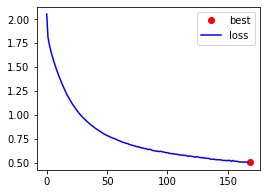

Best epoch so far:  168  smallest loss: 0.5026145001235949
Time taken for the epoch 242.424 sec

Epoch 169 Batch 600 Loss: 0.3867
Epoch 169 Batch 1200 Loss: 0.3067
Epoch 169 Batch 1800 Loss: 0.4026
Epoch 169 Batch 2400 Loss: 0.7636
Epoch 169 Batch 3000 Loss: 0.4565
Epoch 169 Batch 3600 Loss: 0.3918

*** Epoch 169 Loss 0.5074 ***

####################
Greedy| Q: Hello ?  A: i am sorry about the board room 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you want me to 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: i felt pleasure it is a look 
%
Greedy| Q: Who are you ?  A: i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: i do not know it is only a while read 
####################
Best epoch so far:  168  smallest loss: 0.5026145001235949
Time taken for the epoch 242.122 sec

Epoch 170 Batch 600 Loss: 0.4719
Epoch 170 Batch 1200 Loss: 0.3122
Epoch 170 Batch 1800 Loss: 0.4133
Epoch 170 Batch 

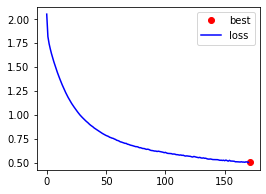

Best epoch so far:  171  smallest loss: 0.5011985116027442
Time taken for the epoch 242.323 sec

Epoch 172 Batch 600 Loss: 0.4883
Epoch 172 Batch 1200 Loss: 0.2567
Epoch 172 Batch 1800 Loss: 0.3845
Epoch 172 Batch 2400 Loss: 0.7634
Epoch 172 Batch 3000 Loss: 0.5222
Epoch 172 Batch 3600 Loss: 0.4342

*** Epoch 172 Loss 0.4998 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what do you want me to mom to the family 
%
Greedy| Q: What are you doing ?  A: it is a poetry 
%
Greedy| Q: What your favorite restaurant ?  A: i felt sad such a station 
%
Greedy| Q: Who are you ?  A: i brought you you know you i am the great man 
%
Greedy| Q: Do you want to go out ?  A: no no but i do not have a good time 
####################
check point saved!
Best epoch so far:  172  smallest loss: 0.4997597894766514
Time taken for the epoch 242.414 sec

Epoch 173 Batch 600 Loss: 0.4204
Epoch 173 Batch 1200 Loss: 0.3553
Epoch 1

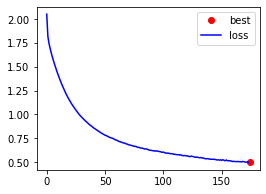

Best epoch so far:  174  smallest loss: 0.49743337258014153
Time taken for the epoch 242.212 sec

Epoch 175 Batch 600 Loss: 0.4753
Epoch 175 Batch 1200 Loss: 0.2594
Epoch 175 Batch 1800 Loss: 0.4577
Epoch 175 Batch 2400 Loss: 0.7178
Epoch 175 Batch 3000 Loss: 0.4388
Epoch 175 Batch 3600 Loss: 0.3704

*** Epoch 175 Loss 0.4995 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what 
%
Greedy| Q: What are you doing ?  A: trying to find out 
%
Greedy| Q: What your favorite restaurant ?  A: i felt sad such a station on a box i have come here to hide them 
%
Greedy| Q: Who are you ?  A: i i am the great trouble 
%
Greedy| Q: Do you want to go out ?  A: i do not have it is going on the water will 
####################
Best epoch so far:  174  smallest loss: 0.49743337258014153
Time taken for the epoch 242.210 sec

Epoch 176 Batch 600 Loss: 0.4449
Epoch 176 Batch 1200 Loss: 0.2905
Epoch 176 Batch 1800 Loss: 0.4

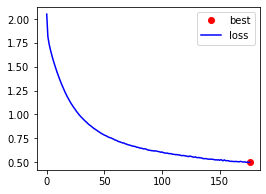

Best epoch so far:  176  smallest loss: 0.49665500917204414
Time taken for the epoch 242.143 sec

Epoch 178 Batch 600 Loss: 0.4542
Epoch 178 Batch 1200 Loss: 0.2970
Epoch 178 Batch 1800 Loss: 0.3940
Epoch 178 Batch 2400 Loss: 0.6326
Epoch 178 Batch 3000 Loss: 0.4057
Epoch 178 Batch 3600 Loss: 0.3316

*** Epoch 178 Loss 0.4915 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine eh 
%
Greedy| Q: Are you my friend ?  A: what do you know me getting one of the moment charlie and he is around you and you 
%
Greedy| Q: What are you doing ?  A: way worked me 
%
Greedy| Q: What your favorite restaurant ?  A: i felt sad such a man 
%
Greedy| Q: Who are you ?  A: i could tell you 
%
Greedy| Q: Do you want to go out ?  A: i do not have it 
####################
check point saved!
Best epoch so far:  178  smallest loss: 0.49146812199686024
Time taken for the epoch 242.166 sec

Epoch 179 Batch 600 Loss: 0.4618
Epoch 179 Batch 1200 Loss: 0.2544
Epoch 179 Bat

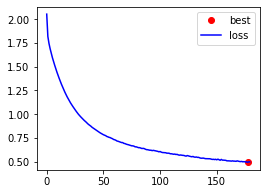

Best epoch so far:  178  smallest loss: 0.49146812199686024
Time taken for the epoch 242.409 sec

Epoch 181 Batch 600 Loss: 0.4062
Epoch 181 Batch 1200 Loss: 0.3363
Epoch 181 Batch 1800 Loss: 0.4170
Epoch 181 Batch 2400 Loss: 0.7090
Epoch 181 Batch 3000 Loss: 0.4744
Epoch 181 Batch 3600 Loss: 0.3813

*** Epoch 181 Loss 0.4966 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine eh i am the old one of those weeks 
%
Greedy| Q: Are you my friend ?  A: what 
%
Greedy| Q: What are you doing ?  A: it was a poetry 
%
Greedy| Q: What your favorite restaurant ?  A: i am not kinda good to see the kitchen 
%
Greedy| Q: Who are you ?  A: i i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: i do not know i am a pair 
####################
Best epoch so far:  178  smallest loss: 0.49146812199686024
Time taken for the epoch 242.136 sec

Epoch 182 Batch 600 Loss: 0.4099
Epoch 182 Batch 1200 Loss: 0.2673
Epoch 182 Batch 1800 Loss: 0.4115
Epoch 182 Batc

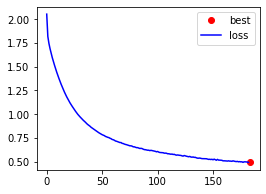

Best epoch so far:  183  smallest loss: 0.4912171714543436
Time taken for the epoch 242.377 sec

Epoch 184 Batch 600 Loss: 0.4453
Epoch 184 Batch 1200 Loss: 0.2405
Epoch 184 Batch 1800 Loss: 0.4120
Epoch 184 Batch 2400 Loss: 0.7385
Epoch 184 Batch 3000 Loss: 0.4672
Epoch 184 Batch 3600 Loss: 0.4344

*** Epoch 184 Loss 0.4907 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine why am i 
%
Greedy| Q: Are you my friend ?  A: what the hell is not you 
%
Greedy| Q: What are you doing ?  A: it here okay 
%
Greedy| Q: What your favorite restaurant ?  A: i felt like you thought you have some wine and a fresh air yes 
%
Greedy| Q: Who are you ?  A: i am the great you cannot have to go i am a messenger so 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything to see them myself 
####################
check point saved!
Best epoch so far:  184  smallest loss: 0.49066719438445394
Time taken for the epoch 242.388 sec

Epoch 185 Batch 600 Loss: 0.

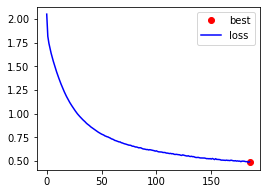

Best epoch so far:  185  smallest loss: 0.4837685785391514
Time taken for the epoch 242.469 sec

Epoch 187 Batch 600 Loss: 0.4250
Epoch 187 Batch 1200 Loss: 0.2546
Epoch 187 Batch 1800 Loss: 0.4084
Epoch 187 Batch 2400 Loss: 0.7280
Epoch 187 Batch 3000 Loss: 0.4252
Epoch 187 Batch 3600 Loss: 0.3396

*** Epoch 187 Loss 0.4868 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine why do not i am frightened 
%
Greedy| Q: Are you my friend ?  A: what about your head or not she once 
%
Greedy| Q: What are you doing ?  A: trying to reach outta here a lot about it 
%
Greedy| Q: What your favorite restaurant ?  A: i felt pleasure 
%
Greedy| Q: Who are you ?  A: i am the great you were married 
%
Greedy| Q: Do you want to go out ?  A: i do not have it 
####################
Best epoch so far:  185  smallest loss: 0.4837685785391514
Time taken for the epoch 242.145 sec

Epoch 188 Batch 600 Loss: 0.4064
Epoch 188 Batch 1200 Loss: 0.2516
Epoch 188 Batch 180

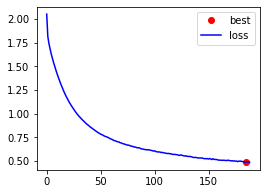

Best epoch so far:  185  smallest loss: 0.4837685785391514
Time taken for the epoch 242.526 sec

Epoch 190 Batch 600 Loss: 0.4331
Epoch 190 Batch 1200 Loss: 0.3167
Epoch 190 Batch 1800 Loss: 0.3784
Epoch 190 Batch 2400 Loss: 0.6091
Epoch 190 Batch 3000 Loss: 0.4230
Epoch 190 Batch 3600 Loss: 0.3198

*** Epoch 190 Loss 0.4856 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what about your back in our language friend 
%
Greedy| Q: What are you doing ?  A: it is elevated 
%
Greedy| Q: What your favorite restaurant ?  A: oh that thing tries i have come by a fresh air near 
%
Greedy| Q: Who are you ?  A: i brought you you know 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything to do something i am a suit 
####################
Best epoch so far:  185  smallest loss: 0.4837685785391514
Time taken for the epoch 241.981 sec

Epoch 191 Batch 600 Loss: 0.4202
Epoch 191 Batch 1200 Loss: 0.1966
Epoch

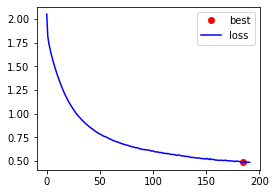

Best epoch so far:  185  smallest loss: 0.4837685785391514
Time taken for the epoch 242.348 sec

Epoch 193 Batch 600 Loss: 0.3600
Epoch 193 Batch 1200 Loss: 0.3254
Epoch 193 Batch 1800 Loss: 0.3926
Epoch 193 Batch 2400 Loss: 0.7094
Epoch 193 Batch 3000 Loss: 0.4134
Epoch 193 Batch 3600 Loss: 0.3790

*** Epoch 193 Loss 0.4814 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what about your letters 
%
Greedy| Q: What are you doing ?  A: it is all maybe i was running late to kill me 
%
Greedy| Q: What your favorite restaurant ?  A: oh a friend david 
%
Greedy| Q: Who are you ?  A: well i i i am the great man 
%
Greedy| Q: Do you want to go out ?  A: i do not think so 
####################
check point saved!
Best epoch so far:  193  smallest loss: 0.4813980835198099
Time taken for the epoch 242.384 sec

Epoch 194 Batch 600 Loss: 0.3981
Epoch 194 Batch 1200 Loss: 0.2746
Epoch 194 Batch 1800 Loss: 0.3811
Epo

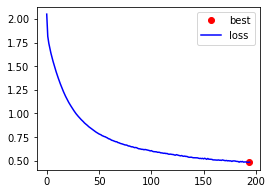

Best epoch so far:  193  smallest loss: 0.4813980835198099
Time taken for the epoch 242.339 sec

Epoch 196 Batch 600 Loss: 0.3898
Epoch 196 Batch 1200 Loss: 0.2674
Epoch 196 Batch 1800 Loss: 0.4384
Epoch 196 Batch 2400 Loss: 0.7494
Epoch 196 Batch 3000 Loss: 0.4581
Epoch 196 Batch 3600 Loss: 0.4318

*** Epoch 196 Loss 0.4820 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what is it 
%
Greedy| Q: What are you doing ?  A: trying to find out 
%
Greedy| Q: What your favorite restaurant ?  A: oh that is the only place 
%
Greedy| Q: Who are you ?  A: i am a crazy 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
Best epoch so far:  193  smallest loss: 0.4813980835198099
Time taken for the epoch 242.023 sec

Epoch 197 Batch 600 Loss: 0.3635
Epoch 197 Batch 1200 Loss: 0.3474
Epoch 197 Batch 1800 Loss: 0.4001
Epoch 197 Batch 2400 Loss: 0.6595
Epoch 197 Batch 3000 Loss: 0.4263
Epoch 197

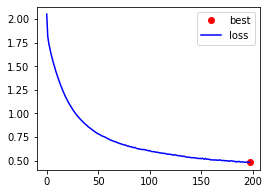

Best epoch so far:  197  smallest loss: 0.48075605398279214
Time taken for the epoch 242.161 sec

Epoch 199 Batch 600 Loss: 0.4680
Epoch 199 Batch 1200 Loss: 0.2675
Epoch 199 Batch 1800 Loss: 0.3965
Epoch 199 Batch 2400 Loss: 0.6977
Epoch 199 Batch 3000 Loss: 0.4303
Epoch 199 Batch 3600 Loss: 0.3275

*** Epoch 199 Loss 0.4825 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what is it 
%
Greedy| Q: What are you doing ?  A: trying to find out 
%
Greedy| Q: What your favorite restaurant ?  A: i am a look 
%
Greedy| Q: Who are you ?  A: you are assholes business number 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
Best epoch so far:  197  smallest loss: 0.48075605398279214
Time taken for the epoch 241.996 sec

Epoch 200 Batch 600 Loss: 0.4205
Epoch 200 Batch 1200 Loss: 0.3004
Epoch 200 Batch 1800 Loss: 0.4484
Epoch 200 Batch 2400 Loss: 0.7655
Epoch 200 Batch 3000 Loss: 0.45

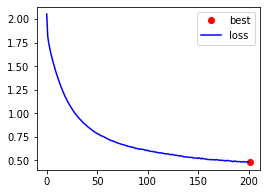

Best epoch so far:  201  smallest loss: 0.4769646916957223
Time taken for the epoch 241.973 sec

Epoch 202 Batch 600 Loss: 0.4174
Epoch 202 Batch 1200 Loss: 0.2892
Epoch 202 Batch 1800 Loss: 0.3917
Epoch 202 Batch 2400 Loss: 0.6335
Epoch 202 Batch 3000 Loss: 0.4471
Epoch 202 Batch 3600 Loss: 0.3265

*** Epoch 202 Loss 0.4823 ***

####################
Greedy| Q: Hello ?  A: yeah how are you keeping the phone 
%
Greedy| Q: How are you ?  A: fine why 
%
Greedy| Q: Are you my friend ?  A: what about what i like mr cook 
%
Greedy| Q: What are you doing ?  A: i am hungry yet 
%
Greedy| Q: What your favorite restaurant ?  A: oh it is a look 
%
Greedy| Q: Who are you ?  A: well i i i am the great daddy 
%
Greedy| Q: Do you want to go out ?  A: maybe for a few things 
####################
Best epoch so far:  201  smallest loss: 0.4769646916957223
Time taken for the epoch 242.210 sec

Epoch 203 Batch 600 Loss: 0.4664
Epoch 203 Batch 1200 Loss: 0.2519
Epoch 203 Batch 1800 Loss: 0.4765
Epoch 203 B

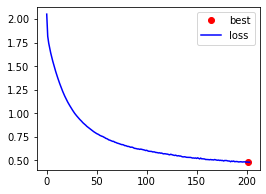

Best epoch so far:  201  smallest loss: 0.4769646916957223
Time taken for the epoch 242.343 sec

Epoch 205 Batch 600 Loss: 0.3810
Epoch 205 Batch 1200 Loss: 0.3017
Epoch 205 Batch 1800 Loss: 0.4271
Epoch 205 Batch 2400 Loss: 0.6861
Epoch 205 Batch 3000 Loss: 0.4472
Epoch 205 Batch 3600 Loss: 0.3484

*** Epoch 205 Loss 0.4761 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am stuck 
%
Greedy| Q: What your favorite restaurant ?  A: i have a money to the doctor 
%
Greedy| Q: Who are you ?  A: i am the great man 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  205  smallest loss: 0.4761184662737649
Time taken for the epoch 242.108 sec

Epoch 206 Batch 600 Loss: 0.4078
Epoch 206 Batch 1200 Loss: 0.2697
Epoch 206 Batch 1800 Loss: 0.4357
Epoch 206 Batch 2400 Loss: 0.5940
Epoch 206 Batch 3000 Loss: 

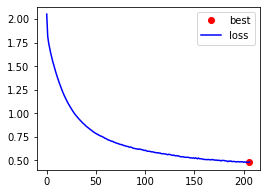

Best epoch so far:  205  smallest loss: 0.4761184662737649
Time taken for the epoch 242.399 sec

Epoch 208 Batch 600 Loss: 0.4509
Epoch 208 Batch 1200 Loss: 0.2581
Epoch 208 Batch 1800 Loss: 0.3831
Epoch 208 Batch 2400 Loss: 0.7789
Epoch 208 Batch 3000 Loss: 0.4697
Epoch 208 Batch 3600 Loss: 0.3515

*** Epoch 208 Loss 0.4773 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what about roger six weeks and she is lying 
%
Greedy| Q: What are you doing ?  A: i am doing fine 
%
Greedy| Q: What your favorite restaurant ?  A: i felt sad pale 
%
Greedy| Q: Who are you ?  A: i brought the girl fuck her about me 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
Best epoch so far:  205  smallest loss: 0.4761184662737649
Time taken for the epoch 242.330 sec

Epoch 209 Batch 600 Loss: 0.3881
Epoch 209 Batch 1200 Loss: 0.3007
Epoch 209 Batch 1800 Loss: 0.3750
Epoch 209 Batch 2400 Loss: 0.

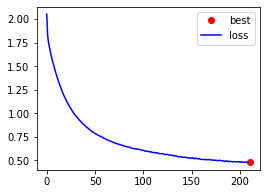

Best epoch so far:  210  smallest loss: 0.4755464670825527
Time taken for the epoch 242.397 sec

Epoch 211 Batch 600 Loss: 0.4259
Epoch 211 Batch 1200 Loss: 0.2522
Epoch 211 Batch 1800 Loss: 0.4332
Epoch 211 Batch 2400 Loss: 0.5981
Epoch 211 Batch 3000 Loss: 0.4216
Epoch 211 Batch 3600 Loss: 0.3496

*** Epoch 211 Loss 0.4715 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what about your head or not she is lying 
%
Greedy| Q: What are you doing ?  A: trying to feel like this 
%
Greedy| Q: What your favorite restaurant ?  A: yeah okay 
%
Greedy| Q: Who are you ?  A: i i know who else 
%
Greedy| Q: Do you want to go out ?  A: no no no no no no no no no no no no no no no no no no 
####################
check point saved!
Best epoch so far:  211  smallest loss: 0.4715317327248994
Time taken for the epoch 242.371 sec

Epoch 212 Batch 600 Loss: 0.4069
Epoch 212 Batch 1200 Loss: 0.2522
Epoch 212 Batch 1800 Lo

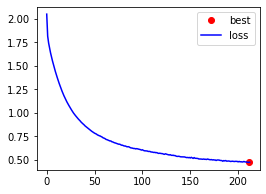

Best epoch so far:  211  smallest loss: 0.4715317327248994
Time taken for the epoch 242.340 sec

Epoch 214 Batch 600 Loss: 0.4516
Epoch 214 Batch 1200 Loss: 0.2893
Epoch 214 Batch 1800 Loss: 0.3927
Epoch 214 Batch 2400 Loss: 0.6100
Epoch 214 Batch 3000 Loss: 0.4162
Epoch 214 Batch 3600 Loss: 0.2900

*** Epoch 214 Loss 0.4675 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am just happy 
%
Greedy| Q: What your favorite restaurant ?  A: i felt that is late i have got a hope 
%
Greedy| Q: Who are you ?  A: i i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything to see anybody 
####################
check point saved!
Best epoch so far:  214  smallest loss: 0.4674932483564044
Time taken for the epoch 242.151 sec

Epoch 215 Batch 600 Loss: 0.4489
Epoch 215 Batch 1200 Loss: 0.2169
Epoch 215 Batch 1800 Loss: 0.4117
Epoch 215 Batch 2400 Lo

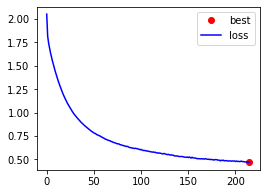

Best epoch so far:  214  smallest loss: 0.4674932483564044
Time taken for the epoch 242.374 sec

Epoch 217 Batch 600 Loss: 0.3744
Epoch 217 Batch 1200 Loss: 0.2778
Epoch 217 Batch 1800 Loss: 0.3851
Epoch 217 Batch 2400 Loss: 0.6566
Epoch 217 Batch 3000 Loss: 0.4743
Epoch 217 Batch 3600 Loss: 0.3558

*** Epoch 217 Loss 0.4693 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: trying to figure say 
%
Greedy| Q: What your favorite restaurant ?  A: i am not surprised so good 
%
Greedy| Q: Who are you ?  A: you know me 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
Best epoch so far:  214  smallest loss: 0.4674932483564044
Time taken for the epoch 241.990 sec

Epoch 218 Batch 600 Loss: 0.4272
Epoch 218 Batch 1200 Loss: 0.2481
Epoch 218 Batch 1800 Loss: 0.3604
Epoch 218 Batch 2400 Loss: 0.5879
Epoch 218 Batch 3000 Loss: 0.4012
Epoch 218 B

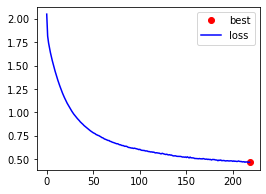

Best epoch so far:  218  smallest loss: 0.4661116143448168
Time taken for the epoch 242.058 sec

Epoch 220 Batch 600 Loss: 0.4242
Epoch 220 Batch 1200 Loss: 0.2428
Epoch 220 Batch 1800 Loss: 0.4216
Epoch 220 Batch 2400 Loss: 0.7314
Epoch 220 Batch 3000 Loss: 0.4402
Epoch 220 Batch 3600 Loss: 0.3862

*** Epoch 220 Loss 0.4710 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: i am not a bad cop 
%
Greedy| Q: Who are you ?  A: i am the great you were 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything to see anybody i am going to need a cab i am going 
####################
Best epoch so far:  218  smallest loss: 0.4661116143448168
Time taken for the epoch 242.158 sec

Epoch 221 Batch 600 Loss: 0.3636
Epoch 221 Batch 1200 Loss: 0.2764
Epoch 221 Batch 1800 Loss: 0.3875
Epoch 221 Batch 2400 Loss

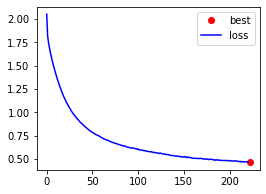

Best epoch so far:  222  smallest loss: 0.46254979032230087
Time taken for the epoch 242.544 sec

Epoch 223 Batch 600 Loss: 0.4101
Epoch 223 Batch 1200 Loss: 0.2384
Epoch 223 Batch 1800 Loss: 0.3953
Epoch 223 Batch 2400 Loss: 0.6658
Epoch 223 Batch 3000 Loss: 0.4211
Epoch 223 Batch 3600 Loss: 0.3244

*** Epoch 223 Loss 0.4636 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine i am fine than just a half me 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am thinking 
%
Greedy| Q: What your favorite restaurant ?  A: i would not have it last night 
%
Greedy| Q: Who are you ?  A: i brought the girl remember 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
Best epoch so far:  222  smallest loss: 0.46254979032230087
Time taken for the epoch 242.251 sec

Epoch 224 Batch 600 Loss: 0.4293
Epoch 224 Batch 1200 Loss: 0.2620
Epoch 224 Batch 1800 Loss: 0.4146
Epoch 224 Batch 2400 Loss: 0.6961


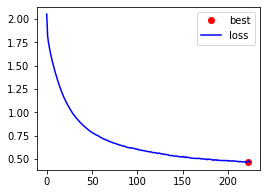

Best epoch so far:  222  smallest loss: 0.46254979032230087
Time taken for the epoch 242.304 sec

Epoch 226 Batch 600 Loss: 0.4403
Epoch 226 Batch 1200 Loss: 0.2496
Epoch 226 Batch 1800 Loss: 0.3972
Epoch 226 Batch 2400 Loss: 0.6047
Epoch 226 Batch 3000 Loss: 0.4590
Epoch 226 Batch 3600 Loss: 0.2576

*** Epoch 226 Loss 0.4736 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am doing here alone i am doing here alone i am doing here alone i am doing 
%
Greedy| Q: What your favorite restaurant ?  A: yeah there is a spider apartment 
%
Greedy| Q: Who are you ?  A: i i know who else 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything to see what he looked at me 
####################
Best epoch so far:  222  smallest loss: 0.46254979032230087
Time taken for the epoch 242.123 sec

Epoch 227 Batch 600 Loss: 0.4801
Epoch 227 Batch 1200 Loss: 0.2075
E

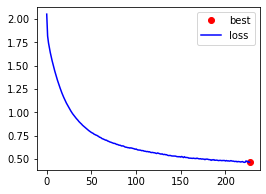

Best epoch so far:  227  smallest loss: 0.4620809224192513
Time taken for the epoch 242.339 sec

Epoch 229 Batch 600 Loss: 0.3495
Epoch 229 Batch 1200 Loss: 0.2902
Epoch 229 Batch 1800 Loss: 0.4119
Epoch 229 Batch 2400 Loss: 0.5962
Epoch 229 Batch 3000 Loss: 0.3985
Epoch 229 Batch 3600 Loss: 0.3517

*** Epoch 229 Loss 0.4576 ***

####################
Greedy| Q: Hello ?  A: i am sorry i have been calling you 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am looking for it 
%
Greedy| Q: What your favorite restaurant ?  A: i would like a look long term 
%
Greedy| Q: Who are you ?  A: well 
%
Greedy| Q: Do you want to go out ?  A: i do not think so 
####################
check point saved!
Best epoch so far:  229  smallest loss: 0.45760782301640995
Time taken for the epoch 242.200 sec

Epoch 230 Batch 600 Loss: 0.4023
Epoch 230 Batch 1200 Loss: 0.2641
Epoch 230 Batch 1800 Loss: 0.3653
Epoch 230 Batch 2400 Loss: 0.5642
E

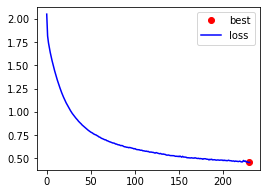

Best epoch so far:  229  smallest loss: 0.45760782301640995
Time taken for the epoch 242.205 sec

Epoch 232 Batch 600 Loss: 0.4144
Epoch 232 Batch 1200 Loss: 0.2155
Epoch 232 Batch 1800 Loss: 0.4220
Epoch 232 Batch 2400 Loss: 0.7003
Epoch 232 Batch 3000 Loss: 0.4231
Epoch 232 Batch 3600 Loss: 0.4049

*** Epoch 232 Loss 0.4568 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine why do not protect you 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am sorry but some people have to do 
%
Greedy| Q: What your favorite restaurant ?  A: yeah it is here 
%
Greedy| Q: Who are you ?  A: well i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  232  smallest loss: 0.456778978130204
Time taken for the epoch 242.199 sec

Epoch 233 Batch 600 Loss: 0.3602
Epoch 233 Batch 1200 Loss: 0.2834
Epoch 233 Batch 1800 Loss: 0.3855
Epoch 233 Batch 2400 

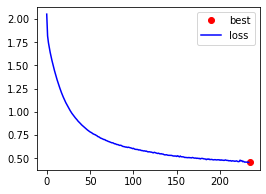

Best epoch so far:  234  smallest loss: 0.4544164449547252
Time taken for the epoch 242.224 sec

Epoch 235 Batch 600 Loss: 0.4050
Epoch 235 Batch 1200 Loss: 0.2131
Epoch 235 Batch 1800 Loss: 0.4363
Epoch 235 Batch 2400 Loss: 0.6628
Epoch 235 Batch 3000 Loss: 0.3679
Epoch 235 Batch 3600 Loss: 0.3529

*** Epoch 235 Loss 0.4535 ***

####################
Greedy| Q: Hello ?  A: hi 
%
Greedy| Q: How are you ?  A: fine fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: pouring it out 
%
Greedy| Q: What your favorite restaurant ?  A: i felt sad such a fresh room 
%
Greedy| Q: Who are you ?  A: i am the one talking they say mr from me 
%
Greedy| Q: Do you want to go out ?  A: i do not think so 
####################
check point saved!
Best epoch so far:  235  smallest loss: 0.4534514694785595
Time taken for the epoch 242.114 sec

Epoch 236 Batch 600 Loss: 0.4046
Epoch 236 Batch 1200 Loss: 0.2315
Epoch 236 Batch 1800 Loss: 0.3773
Epoch 236 Batch 2400 Loss: 0.6881

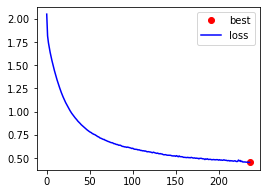

Best epoch so far:  236  smallest loss: 0.453218610955714
Time taken for the epoch 242.187 sec

Epoch 238 Batch 600 Loss: 0.3860
Epoch 238 Batch 1200 Loss: 0.2463
Epoch 238 Batch 1800 Loss: 0.3869
Epoch 238 Batch 2400 Loss: 0.5809
Epoch 238 Batch 3000 Loss: 0.4237
Epoch 238 Batch 3600 Loss: 0.2786

*** Epoch 238 Loss 0.4486 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine i am a free country i am a free country i am a free country i am 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: pouring it out where you burn up with me 
%
Greedy| Q: What your favorite restaurant ?  A: i felt that is a vacation 
%
Greedy| Q: Who are you ?  A: i am agent to get worked 
%
Greedy| Q: Do you want to go out ?  A: i do not know 
####################
check point saved!
Best epoch so far:  238  smallest loss: 0.4485783128317548
Time taken for the epoch 242.054 sec

Epoch 239 Batch 600 Loss: 0.4268
Epoch 239 Batch 1200 Loss: 0.216

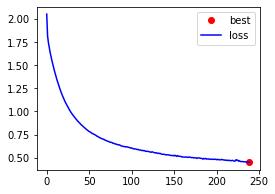

Best epoch so far:  238  smallest loss: 0.4485783128317548
Time taken for the epoch 242.390 sec

Epoch 241 Batch 600 Loss: 0.3589
Epoch 241 Batch 1200 Loss: 0.2619
Epoch 241 Batch 1800 Loss: 0.4384
Epoch 241 Batch 2400 Loss: 0.6597
Epoch 241 Batch 3000 Loss: 0.4368
Epoch 241 Batch 3600 Loss: 0.3806

*** Epoch 241 Loss 0.4609 ***

####################
Greedy| Q: Hello ?  A: i am waiting mr men in military special pro 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what 
%
Greedy| Q: What are you doing ?  A: trying to save the world see ya going to kill him 
%
Greedy| Q: What your favorite restaurant ?  A: that is right 
%
Greedy| Q: Who are you ?  A: well i i i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: no no i do not know 
####################
Best epoch so far:  238  smallest loss: 0.4485783128317548
Time taken for the epoch 241.994 sec

Epoch 242 Batch 600 Loss: 0.3676
Epoch 242 Batch 1200 Loss: 0.2773
Epoch 242 Batch 1800 Loss: 0.3805
Epoch 2

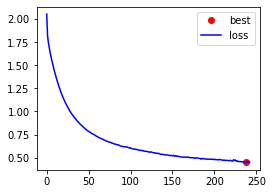

Best epoch so far:  238  smallest loss: 0.4485783128317548
Time taken for the epoch 242.188 sec

Epoch 244 Batch 600 Loss: 0.3916
Epoch 244 Batch 1200 Loss: 0.2506
Epoch 244 Batch 1800 Loss: 0.4071
Epoch 244 Batch 2400 Loss: 0.6775
Epoch 244 Batch 3000 Loss: 0.4414
Epoch 244 Batch 3600 Loss: 0.3988

*** Epoch 244 Loss 0.4470 ***

####################
Greedy| Q: Hello ?  A: i am so glad you 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am going to kill you 
%
Greedy| Q: What your favorite restaurant ?  A: got a look time to see a message you know 
%
Greedy| Q: Who are you ?  A: well i i i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: i do not have anything to do something you know he is got a company 
####################
check point saved!
Best epoch so far:  244  smallest loss: 0.44702172153630654
Time taken for the epoch 242.146 sec

Epoch 245 Batch 600 Loss: 0.3302
Epoch 245 Batch 1200 Loss: 0.2939
E

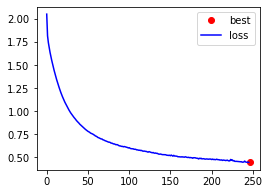

Best epoch so far:  246  smallest loss: 0.446500000542083
Time taken for the epoch 241.943 sec

Epoch 247 Batch 600 Loss: 0.4015
Epoch 247 Batch 1200 Loss: 0.2467
Epoch 247 Batch 1800 Loss: 0.4151
Epoch 247 Batch 2400 Loss: 0.6678
Epoch 247 Batch 3000 Loss: 0.4001
Epoch 247 Batch 3600 Loss: 0.3253

*** Epoch 247 Loss 0.4502 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am looking for it 
%
Greedy| Q: What your favorite restaurant ?  A: yeah i felt that is that other 
%
Greedy| Q: Who are you ?  A: i i i am the one talking they are into me 
%
Greedy| Q: Do you want to go out ?  A: i do not know where i am going to need a cab 
####################
Best epoch so far:  246  smallest loss: 0.446500000542083
Time taken for the epoch 241.938 sec

Epoch 248 Batch 600 Loss: 0.4123
Epoch 248 Batch 1200 Loss: 0.2252
Epoch 248 Batch 1800 Loss: 0.3829
Epoch 248 Batch 2

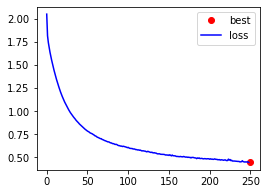

Best epoch so far:  249  smallest loss: 0.4430448313471413
Time taken for the epoch 242.141 sec

Epoch 250 Batch 600 Loss: 0.3755
Epoch 250 Batch 1200 Loss: 0.2157
Epoch 250 Batch 1800 Loss: 0.4037
Epoch 250 Batch 2400 Loss: 0.5707
Epoch 250 Batch 3000 Loss: 0.3881
Epoch 250 Batch 3600 Loss: 0.2680

*** Epoch 250 Loss 0.4412 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine why do not let anything happen if you would not let me see what i am taking 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am thinking 
%
Greedy| Q: What your favorite restaurant ?  A: some kids and your wife hung it with it 
%
Greedy| Q: Who are you ?  A: i brought you back to the girl remember 
%
Greedy| Q: Do you want to go out ?  A: i do not have him 
####################
check point saved!
Best epoch so far:  250  smallest loss: 0.4412321736009922
Time taken for the epoch 242.259 sec

Epoch 251 Batch 600 Loss: 0.4376
Epoch 251 Batc

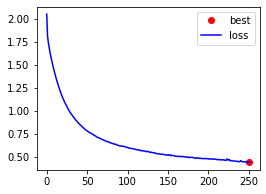

Best epoch so far:  250  smallest loss: 0.4412321736009922
Time taken for the epoch 242.312 sec

Epoch 253 Batch 600 Loss: 0.3775
Epoch 253 Batch 1200 Loss: 0.3085
Epoch 253 Batch 1800 Loss: 0.4490
Epoch 253 Batch 2400 Loss: 0.6623
Epoch 253 Batch 3000 Loss: 0.3991
Epoch 253 Batch 3600 Loss: 0.3596

*** Epoch 253 Loss 0.4424 ***

####################
Greedy| Q: Hello ?  A: god i have been calling the phone 
%
Greedy| Q: How are you ?  A: fine why do not notice me 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i have not even shut up get out my head i was really 
%
Greedy| Q: What your favorite restaurant ?  A: no thank you 
%
Greedy| Q: Who are you ?  A: i am here 
%
Greedy| Q: Do you want to go out ?  A: i do not know it is in the world what 
####################
Best epoch so far:  250  smallest loss: 0.4412321736009922
Time taken for the epoch 242.128 sec

Epoch 254 Batch 600 Loss: 0.4198
Epoch 254 Batch 1200 Loss: 0.2608
Epoch 254 Batch 1800 Loss: 0

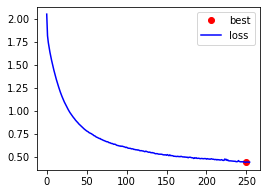

Best epoch so far:  250  smallest loss: 0.4412321736009922
Time taken for the epoch 242.236 sec

Epoch 256 Batch 600 Loss: 0.4273
Epoch 256 Batch 1200 Loss: 0.2353
Epoch 256 Batch 1800 Loss: 0.4038
Epoch 256 Batch 2400 Loss: 0.6888
Epoch 256 Batch 3000 Loss: 0.3693
Epoch 256 Batch 3600 Loss: 0.3561

*** Epoch 256 Loss 0.4449 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am going to refill my pulse 
%
Greedy| Q: What your favorite restaurant ?  A: no thank you 
%
Greedy| Q: Who are you ?  A: well i am the one who you were married 
%
Greedy| Q: Do you want to go out ?  A: no i do not know 
####################
Best epoch so far:  250  smallest loss: 0.4412321736009922
Time taken for the epoch 242.383 sec

Epoch 257 Batch 600 Loss: 0.3484
Epoch 257 Batch 1200 Loss: 0.2620
Epoch 257 Batch 1800 Loss: 0.4519
Epoch 257 Batch 2400 Loss: 0.6226
Epoch 257 Batch

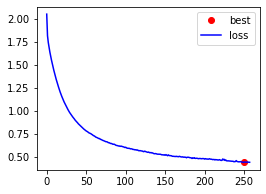

Best epoch so far:  250  smallest loss: 0.4412321736009922
Time taken for the epoch 242.459 sec

Epoch 259 Batch 600 Loss: 0.4048
Epoch 259 Batch 1200 Loss: 0.1826
Epoch 259 Batch 1800 Loss: 0.4333
Epoch 259 Batch 2400 Loss: 0.6226
Epoch 259 Batch 3000 Loss: 0.3761
Epoch 259 Batch 3600 Loss: 0.2999

*** Epoch 259 Loss 0.4410 ***

####################
Greedy| Q: Hello ?  A: god i have been calling you 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am looking for it 
%
Greedy| Q: What your favorite restaurant ?  A: no thank you 
%
Greedy| Q: Who are you ?  A: well i i i am the one who else 
%
Greedy| Q: Do you want to go out ?  A: i do not have a headache 
####################
check point saved!
Best epoch so far:  259  smallest loss: 0.4410313657347176
Time taken for the epoch 242.195 sec

Epoch 260 Batch 600 Loss: 0.3733
Epoch 260 Batch 1200 Loss: 0.2778
Epoch 260 Batch 1800 Loss: 0.3943
Epoch 260 Batch 2400 Loss: 

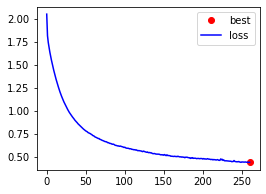

Best epoch so far:  260  smallest loss: 0.44057577886483484
Time taken for the epoch 242.288 sec

Epoch 262 Batch 600 Loss: 0.4187
Epoch 262 Batch 1200 Loss: 0.2607
Epoch 262 Batch 1800 Loss: 0.4360
Epoch 262 Batch 2400 Loss: 0.5609
Epoch 262 Batch 3000 Loss: 0.4169
Epoch 262 Batch 3600 Loss: 0.2497

*** Epoch 262 Loss 0.4436 ***

####################
Greedy| Q: Hello ?  A: god i have been calling you 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am alone here what are you doing 
%
Greedy| Q: What your favorite restaurant ?  A: i have got a boss back to the wife 
%
Greedy| Q: Who are you ?  A: i i know who you were married 
%
Greedy| Q: Do you want to go out ?  A: i do not know it 
####################
Best epoch so far:  260  smallest loss: 0.44057577886483484
Time taken for the epoch 242.099 sec

Epoch 263 Batch 600 Loss: 0.4012
Epoch 263 Batch 1200 Loss: 0.2215
Epoch 263 Batch 1800 Loss: 0.4397
Epoch 263 Batch 

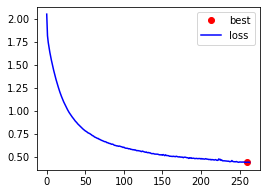

Best epoch so far:  260  smallest loss: 0.44057577886483484
Time taken for the epoch 242.577 sec

Epoch 265 Batch 600 Loss: 0.3511
Epoch 265 Batch 1200 Loss: 0.2717
Epoch 265 Batch 1800 Loss: 0.4279
Epoch 265 Batch 2400 Loss: 0.5948
Epoch 265 Batch 3000 Loss: 0.4093
Epoch 265 Batch 3600 Loss: 0.3582

*** Epoch 265 Loss 0.4370 ***

####################
Greedy| Q: Hello ?  A: i am so glad to talk to me 
%
Greedy| Q: How are you ?  A: fine why do not push old friends 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am alone here alone i was really getting out there i am doing 
%
Greedy| Q: What your favorite restaurant ?  A: no thank you 
%
Greedy| Q: Who are you ?  A: well i i i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: i do not have some friends 
####################
check point saved!
Best epoch so far:  265  smallest loss: 0.43698214134705454
Time taken for the epoch 242.358 sec

Epoch 266 Batch 600 Loss: 0.3994
Epoch 266 Batch 1200 Los

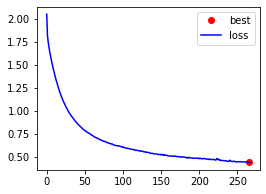

Best epoch so far:  265  smallest loss: 0.43698214134705454
Time taken for the epoch 242.357 sec

Epoch 268 Batch 600 Loss: 0.4377
Epoch 268 Batch 1200 Loss: 0.2468
Epoch 268 Batch 1800 Loss: 0.3927
Epoch 268 Batch 2400 Loss: 0.6277
Epoch 268 Batch 3000 Loss: 0.3848
Epoch 268 Batch 3600 Loss: 0.4052

*** Epoch 268 Loss 0.4379 ***

####################
Greedy| Q: Hello ?  A: god i have been calling you 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: pouring it up 
%
Greedy| Q: What your favorite restaurant ?  A: i have a bowling joe has anyone meeting could work it 
%
Greedy| Q: Who are you ?  A: i have been calling me man 
%
Greedy| Q: Do you want to go out ?  A: i do not think so 
####################
Best epoch so far:  265  smallest loss: 0.43698214134705454
Time taken for the epoch 242.181 sec

Epoch 269 Batch 600 Loss: 0.3432
Epoch 269 Batch 1200 Loss: 0.2664
Epoch 269 Batch 1800 Loss: 0.4280
Epoch 269 Batch 2400

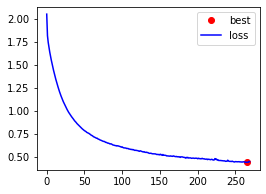

Best epoch so far:  265  smallest loss: 0.43698214134705454
Time taken for the epoch 242.298 sec

Epoch 271 Batch 600 Loss: 0.3615
Epoch 271 Batch 1200 Loss: 0.2194
Epoch 271 Batch 1800 Loss: 0.3957
Epoch 271 Batch 2400 Loss: 0.6032
Epoch 271 Batch 3000 Loss: 0.3806
Epoch 271 Batch 3600 Loss: 0.2891

*** Epoch 271 Loss 0.4364 ***

####################
Greedy| Q: Hello ?  A: i am over the phone 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am getting out there is only a lot ted stay a hundred 
%
Greedy| Q: What your favorite restaurant ?  A: no 
%
Greedy| Q: Who are you ?  A: well i i i am a messenger so 
%
Greedy| Q: Do you want to go out ?  A: i do not have him 
####################
check point saved!
Best epoch so far:  271  smallest loss: 0.43644446278491883
Time taken for the epoch 242.331 sec

Epoch 272 Batch 600 Loss: 0.3724
Epoch 272 Batch 1200 Loss: 0.2464
Epoch 272 Batch 1800 Loss: 0.4111
Epoch 272 Batch 

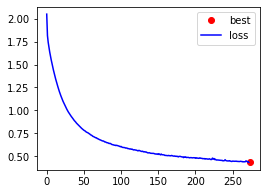

Best epoch so far:  273  smallest loss: 0.431488062519515
Time taken for the epoch 242.272 sec

Epoch 274 Batch 600 Loss: 0.3784
Epoch 274 Batch 1200 Loss: 0.2395
Epoch 274 Batch 1800 Loss: 0.3823
Epoch 274 Batch 2400 Loss: 0.5860
Epoch 274 Batch 3000 Loss: 0.4149
Epoch 274 Batch 3600 Loss: 0.3436

*** Epoch 274 Loss 0.4339 ***

####################
Greedy| Q: Hello ?  A: hi 
%
Greedy| Q: How are you ?  A: fine fine fine just a half 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am looking for it later your piece of organizing 
%
Greedy| Q: What your favorite restaurant ?  A: no 
%
Greedy| Q: Who are you ?  A: i am tom whos lets stay with you i am a messenger 
%
Greedy| Q: Do you want to go out ?  A: i do not have so bad 
####################
Best epoch so far:  273  smallest loss: 0.431488062519515
Time taken for the epoch 242.270 sec

Epoch 275 Batch 600 Loss: 0.3713
Epoch 275 Batch 1200 Loss: 0.2174
Epoch 275 Batch 1800 Loss: 0.4203
Epoch 275 Batch

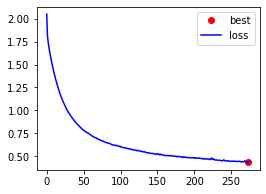

Best epoch so far:  273  smallest loss: 0.431488062519515
Time taken for the epoch 242.366 sec

Epoch 277 Batch 600 Loss: 0.3543
Epoch 277 Batch 1200 Loss: 0.3097
Epoch 277 Batch 1800 Loss: 0.3796
Epoch 277 Batch 2400 Loss: 0.6448
Epoch 277 Batch 3000 Loss: 0.3915
Epoch 277 Batch 3600 Loss: 0.3620

*** Epoch 277 Loss 0.4340 ***

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine more 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am looking for me 
%
Greedy| Q: What your favorite restaurant ?  A: claire and wanting me a man 
%
Greedy| Q: Who are you ?  A: well i i i am a messenger so 
%
Greedy| Q: Do you want to go out ?  A: i do not have much know 
####################
Best epoch so far:  273  smallest loss: 0.431488062519515
Time taken for the epoch 242.112 sec

Epoch 278 Batch 600 Loss: 0.3726
Epoch 278 Batch 1200 Loss: 0.2557
Epoch 278 Batch 1800 Loss: 0.3728
Epoch 278 Batch 2400 Loss: 0.5326
Epoch 278 Batch

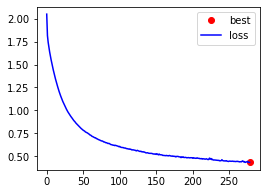

Best epoch so far:  278  smallest loss: 0.4314642786284867
Time taken for the epoch 242.248 sec

Epoch 280 Batch 600 Loss: 0.3911
Epoch 280 Batch 1200 Loss: 0.2325
Epoch 280 Batch 1800 Loss: 0.3887
Epoch 280 Batch 2400 Loss: 0.6777
Epoch 280 Batch 3000 Loss: 0.3660
Epoch 280 Batch 3600 Loss: 0.3673

*** Epoch 280 Loss 0.4317 ***

####################
Greedy| Q: Hello ?  A: i am so glad to see you 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i have not even shut cold 
%
Greedy| Q: What your favorite restaurant ?  A: claire and six oclock 
%
Greedy| Q: Who are you ?  A: i brought you to get worked up 
%
Greedy| Q: Do you want to go out ?  A: i do not know it is in the seat of the fucking job 
####################
Best epoch so far:  278  smallest loss: 0.4314642786284867
Time taken for the epoch 242.285 sec

Epoch 281 Batch 600 Loss: 0.3231
Epoch 281 Batch 1200 Loss: 0.2462
Epoch 281 Batch 1800 Loss: 0.4298
Epoch 281

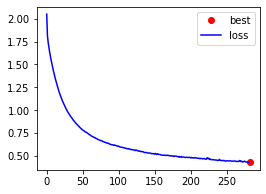

Best epoch so far:  282  smallest loss: 0.427694396379753
Time taken for the epoch 242.409 sec

Epoch 283 Batch 600 Loss: 0.3756
Epoch 283 Batch 1200 Loss: 0.1995
Epoch 283 Batch 1800 Loss: 0.3986
Epoch 283 Batch 2400 Loss: 0.6658
Epoch 283 Batch 3000 Loss: 0.3558
Epoch 283 Batch 3600 Loss: 0.3102

*** Epoch 283 Loss 0.4282 ***

####################
Greedy| Q: Hello ?  A: god i have been calling you 
%
Greedy| Q: How are you ?  A: fine eh i am was a lovely story 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: pouring it out of your head whos calling for it i was really getting out my head got 
%
Greedy| Q: What your favorite restaurant ?  A: it is got no courthouse 
%
Greedy| Q: Who are you ?  A: i brought him to be someone i liked it 
%
Greedy| Q: Do you want to go out ?  A: i do not know it is in so 
####################
Best epoch so far:  282  smallest loss: 0.427694396379753
Time taken for the epoch 242.326 sec

Epoch 284 Batch 600 Loss: 0.4417
Epoc

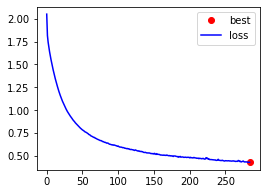

Best epoch so far:  284  smallest loss: 0.42677261814156603
Time taken for the epoch 242.323 sec

Epoch 286 Batch 600 Loss: 0.3686
Epoch 286 Batch 1200 Loss: 0.2051
Epoch 286 Batch 1800 Loss: 0.3916
Epoch 286 Batch 2400 Loss: 0.5497
Epoch 286 Batch 3000 Loss: 0.3962
Epoch 286 Batch 3600 Loss: 0.2669

*** Epoch 286 Loss 0.4292 ***

####################
Greedy| Q: Hello ?  A: god i have been calling you 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: what 
%
Greedy| Q: What are you doing ?  A: i am looking for it i was really getting to talk to me to be bad 
%
Greedy| Q: What your favorite restaurant ?  A: claire and i thought of its insurance 
%
Greedy| Q: Who are you ?  A: i brought him to do 
%
Greedy| Q: Do you want to go out ?  A: i do not know it is in so much 
####################
Best epoch so far:  284  smallest loss: 0.42677261814156603
Time taken for the epoch 242.161 sec

Epoch 287 Batch 600 Loss: 0.4096
Epoch 287 Batch 1200 Loss: 0.2332
Epoch 287 B

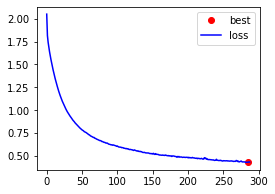

Best epoch so far:  284  smallest loss: 0.42677261814156603
Time taken for the epoch 242.167 sec

Epoch 289 Batch 600 Loss: 0.3416
Epoch 289 Batch 1200 Loss: 0.2816
Epoch 289 Batch 1800 Loss: 0.3663
Epoch 289 Batch 2400 Loss: 0.6427
Epoch 289 Batch 3000 Loss: 0.3784
Epoch 289 Batch 3600 Loss: 0.3378

*** Epoch 289 Loss 0.4264 ***

####################
Greedy| Q: Hello ?  A: i am waiting late the phone 
%
Greedy| Q: How are you ?  A: fine why does everyone did in five weeks 
%
Greedy| Q: Are you my friend ?  A: no but an asshole 
%
Greedy| Q: What are you doing ?  A: i am looking for it 
%
Greedy| Q: What your favorite restaurant ?  A: claire and i hear a matter you are a real jacob 
%
Greedy| Q: Who are you ?  A: i brought you to get worked 
%
Greedy| Q: Do you want to go out ?  A: i do not know it is 
####################
check point saved!
Best epoch so far:  289  smallest loss: 0.4264212128456321
Time taken for the epoch 242.150 sec

Epoch 290 Batch 600 Loss: 0.3577
Epoch 290 Batch 

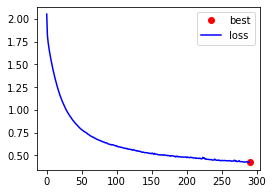

Best epoch so far:  290  smallest loss: 0.4238803343676277
Time taken for the epoch 242.329 sec

Epoch 292 Batch 600 Loss: 0.3890
Epoch 292 Batch 1200 Loss: 0.1960
Epoch 292 Batch 1800 Loss: 0.3938
Epoch 292 Batch 2400 Loss: 0.5841
Epoch 292 Batch 3000 Loss: 0.3754
Epoch 292 Batch 3600 Loss: 0.3877

*** Epoch 292 Loss 0.4260 ***

####################
Greedy| Q: Hello ?  A: i am sorry this is 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: pouring your family have you got to kill him 
%
Greedy| Q: What your favorite restaurant ?  A: claire and you know this good 
%
Greedy| Q: Who are you ?  A: i could be paid i do not know 
%
Greedy| Q: Do you want to go out ?  A: i would rather keep your little while let me warm harry 
####################
Best epoch so far:  290  smallest loss: 0.4238803343676277
Time taken for the epoch 242.360 sec

Epoch 293 Batch 600 Loss: 0.3435
Epoch 293 Batch 1200 Loss: 0.3385
Epoch 293 Batch 1

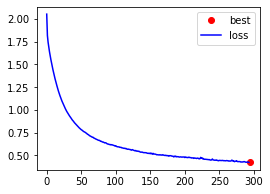

Best epoch so far:  294  smallest loss: 0.4233327966711768
Time taken for the epoch 242.296 sec

Epoch 295 Batch 600 Loss: 0.3472
Epoch 295 Batch 1200 Loss: 0.2302
Epoch 295 Batch 1800 Loss: 0.3702
Epoch 295 Batch 2400 Loss: 0.5949
Epoch 295 Batch 3000 Loss: 0.3493
Epoch 295 Batch 3600 Loss: 0.2951

*** Epoch 295 Loss 0.4249 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: i am sorry 
%
Greedy| Q: What your favorite restaurant ?  A: claire and your left you know 
%
Greedy| Q: Who are you ?  A: i am the great and dr grant is through do you accept 
%
Greedy| Q: Do you want to go out ?  A: when you are 
####################
Best epoch so far:  294  smallest loss: 0.4233327966711768
Time taken for the epoch 242.049 sec

Epoch 296 Batch 600 Loss: 0.3777
Epoch 296 Batch 1200 Loss: 0.1986
Epoch 296 Batch 1800 Loss: 0.3568
Epoch 296 Batch 2400 Loss: 0.6132
Epoch 296 Batch 

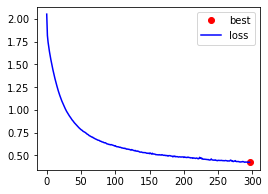

Best epoch so far:  296  smallest loss: 0.4226557011409763
Time taken for the epoch 242.290 sec

Epoch 298 Batch 600 Loss: 0.3876
Epoch 298 Batch 1200 Loss: 0.1986
Epoch 298 Batch 1800 Loss: 0.3322
Epoch 298 Batch 2400 Loss: 0.5212
Epoch 298 Batch 3000 Loss: 0.3833
Epoch 298 Batch 3600 Loss: 0.2922

*** Epoch 298 Loss 0.4263 ***

####################
Greedy| Q: Hello ?  A: hello 
%
Greedy| Q: How are you ?  A: fine why do not look at the moment 
%
Greedy| Q: Are you my friend ?  A: no 
%
Greedy| Q: What are you doing ?  A: it is a long time 
%
Greedy| Q: What your favorite restaurant ?  A: claire and you will not mind it is a look 
%
Greedy| Q: Who are you ?  A: i could be here 
%
Greedy| Q: Do you want to go out ?  A: surely i have not yet 
####################
Best epoch so far:  296  smallest loss: 0.4226557011409763
Time taken for the epoch 242.004 sec

Epoch 299 Batch 600 Loss: 0.3736
Epoch 299 Batch 1200 Loss: 0.1623
Epoch 299 Batch 1800 Loss: 0.3995
Epoch 299 Batch 2400 Loss: 0.

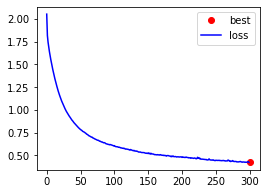

Best epoch so far:  300  smallest loss: 0.4221169045326811
Time taken for the epoch 242.444 sec

Epoch 301 Batch 600 Loss: 0.3246
Epoch 301 Batch 1200 Loss: 0.2540
Epoch 301 Batch 1800 Loss: 0.4054


KeyboardInterrupt: 

In [35]:
batch_loss = K.constant(0)
X, y = [], []
for ep in range(current_ep,EPOCHS):
    current_ep = ep    
    start = time.time()
    total_loss = 0
    btch = 1

    for p in pairs_final_train:     
        
        question = p[0]
        label = p[1]
        # find the index of each word of the caption in vocabulary
        question_seq = [wordtoix[word] for word in question.split(' ') if word in wordtoix]
        label_seq = [wordtoix[word] for word in label.split(' ') if word in wordtoix]
        # encoder input and decoder input and label
        enc_in_seq = pad_sequences([question_seq], maxlen=max_len_q, padding='post')[0]
        dec_out_seq = pad_sequences([label_seq], maxlen=max_len_a, padding='post')[0]
        
        X.append(enc_in_seq)
        y.append(dec_out_seq)

        if len(X) == batch_size :
            batch_loss = train_step(np.array(X), np.array(y), enc_hidden)
            total_loss += batch_loss
            X , y = [], []
            btch += 1
            if btch % (steps_per_epoch//6) == 0:
                print('Epoch {} Batch {} Loss: {:.4f}'.format(ep , btch, K.get_value(batch_loss)))

    epoch_loss =  K.get_value(total_loss) / steps_per_epoch
    print('\n*** Epoch {} Loss {:.4f} ***\n'.format(ep ,epoch_loss))
    history['loss'].append(epoch_loss)
    
    checkpoint.save(file_prefix = checkpoint_prefix)
    test_bot(k=5)

    if epoch_loss < smallest_loss:
        smallest_loss = epoch_loss
        best_ep = ep 
        print('check point saved!')
    
    if ep % 3 == 0:
        plot_history()
        
    print('Best epoch so far: ',best_ep,' smallest loss:',smallest_loss)
    print('Time taken for the epoch {:.3f} sec\n'.format(time.time() - start))

    print('=' * 40)   

It appears that themodel is not getting better anymore, it is overfitting. so I stop the training here and I use the check point at epoch 82 as the inference model.

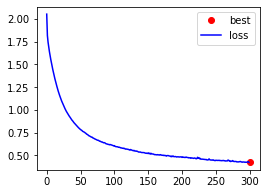

In [36]:
plot_history()

## Test

In [201]:
checkpoint.restore(snapshot_folder+'/'+str(emb_dim)+"-ckpt-120") 

In [202]:
test_bot()

####################
Greedy| Q: Hello ?  A: surprised 
%
Greedy| Q: How are you ?  A: fine 
%
Greedy| Q: Are you my friend ?  A: yes 
%
Greedy| Q: What are you doing ?  A: i am telling you i was alone jake and you are taking an unfortunate accident 
%
Greedy| Q: What your favorite restaurant ?  A: i am a married person at the kitchen 
%
Greedy| Q: Who are you ?  A: we hung out last night remember 
%
Greedy| Q: Do you want to go out ?  A: i have nothing to see it 
####################


Input: i like you
Predicted answer: i know 


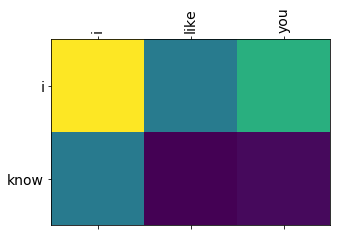

In [203]:
q = "I like you"
answer(q, training=False)

Input: how do you answer
Predicted answer: i do not know 


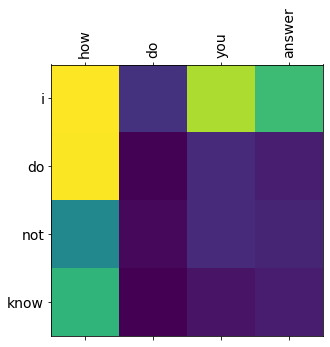

In [204]:
q = "How do you answer"
answer(q, training=False)

Input: are you hungry
Predicted answer: yes i am hungry of people 


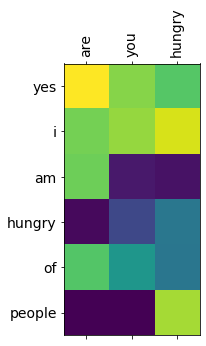

In [209]:
q = "are you hungry"
answer(q, training=False)

Input: who are you
Predicted answer: we hung out last night remember 


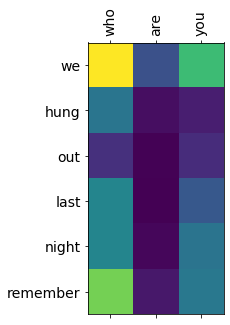

In [206]:
q = "who are you"
answer(q, training=False)

Input: do you drink
Predicted answer: no thank you very much 


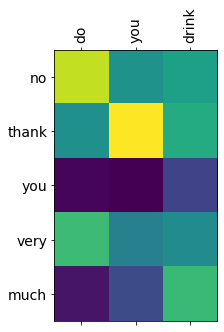

In [207]:
q = "Do you drink"
answer(q, training=False)